# Informations

## One script = one condition to make it easier to follow and correct.

### I am working in local for this analysis

### This script starts by taking the variant counts csv files and concatenate them together in a long df with all the reads and other informations. 

### After, with the long dataframe containing all reads for all variants it does some quality control. Then it calculates the selection coefficient. The last steps are the heatmaps and variants categorization.

#### The goal of the script is to be a linear analysis where it's easy to find information back, so it's not made to make tests. If something is wrong at any quality control step, go in another notebook to find the problem. I open other notebooks for most quality control and if there are a lot of figures to make or other things to verify.

### 1- Wide to long dataframe
### 2- Lanes control
### 3- Selection coefficient
### 4- Replicates control
### 5- Codons control
### 6- Overlaps control
### 7- Heatmaps and figures
### 8-T test 


#### I save the dataframes along the way to be able to use them elsewhere. Dataframes and figures are saved automatically with the information given at the beginning (date+experiment).

In [1]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


In [2]:
# Set up
# Here we can find all informations needed to run the script without changing code along the way. It limits errors.

##Condition

condition = "Itraconazole" #complete name
cond = "Itra" #abbreviation useed in the dataframes

##date + experiment

date = "2023-12-06" #date of this analysis
date_info = "2023-06-20" #date on the reads information files
year = "2023" #year on the reads count files

experiment = "NovaSeq_winter2023_albicans"

## lists

cancel_list = [92,228, 232,233,234] #positions that did not work for any reasons

stop_list = [55,89,119,139,197,238,307,370,408,466,506] #list of stop codons in the library

#positions lists

f1_f2_over = [154,155,158,162]
f2_f3_over = [276,277,280] #275 was supposed to be there, but it's cut because of the primer
f3_f4_over = [401,402,403,404,405,406] #407 was supposed to be there, but it's cut because of the primer

over_list = [154,155,158,162,276,277,280,401,402,403,404,405,406] #all overlap

#codons

Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

DNA_Codons = {"GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A","TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D","GAA": "E", "GAG": "E","TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G","CAT": "H", "CAC": "H","ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K", "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M","AAT": "N", "AAC": "N","CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P","CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R","TCT": "S", "TCC": "S", "TCA": "S", 
    "TCG": "S", "AGT": "S", "AGC": "S","ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V","TGG": "W","TAT": "Y", "TAC": "Y","TAA": "*", "TAG": "*", "TGA": "*"}

In [4]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

# 1- Wide to long dataframe

In [6]:
##takes all variant counts csv files to have a long df

##sorry this is the most horrible function I ever made (but somehow it works)

def wide_to_long(path_vari, path_info):
    
    df_info = pd.read_excel(path_info, header=0)
    df_info = df_info.sort_values(by='Name', ignore_index=True)
    
    files = [os.path.join(path_vari, i) for i in os.listdir(path_vari) if os.path.isfile(os.path.join(path_vari, i))]
    
    name_list = []
    
    # Get a list of the files names
    for name in files:
        file_name = os.path.splitext(os.path.basename(name))[0]
        name_list.append(file_name)
    
    dict_df = {}
    
    # For every file in the folder, read it and append to an empty dict
    for i in range(len(files)):
        print(str(files[i]))
        df = pd.read_csv(files[i], index_col=0)
        dict_df[name_list[i]] = df
        
    dict_melt = {}
    
    # Variants df wide to long
    for key in dict_df:
        df_reads = dict_df[key]
        dfm = df_reads.melt(ignore_index=False).reset_index()
        dfm = dfm.rename(columns={"index": "codon", "variable": "position", "value": "nbr_reads"})
        dict_melt[key] = dfm
        
    dict_df_long = {}
    inter = 0
    
    # Add the info in the long df
    for key in dict_melt:
        info = df_info

        times = len(dict_melt[key])
        con = info.iloc[inter, 3]
        tp = info.iloc[inter, 5]
        ant = info.iloc[inter, 6]
        frag = info.iloc[inter, 7]
        rep = info.iloc[inter, 8]
        la = info.iloc[inter, 9]
        OD = info.iloc[inter, 10]
        want = info.iloc[inter, 11]
        beef = info.iloc[inter, 12]
        afme = info.iloc[inter, 14]
        single = info.iloc[inter, 19]
        align = info.iloc[inter, 21]
        wt = info.iloc[inter, 22]

        chunk = pd.DataFrame({'Condition': [con], 'Timepoint': [tp], "Antifungal": [ant], "Fragment": [frag],
                              "Replicate": [rep], "Lane": [la], "OD": [OD], "reads_wanted": [want], "reads_before": [beef],
                              "reads_after_merge": [afme], "nbr_reads_single": [single], "reads_align": [align],
                              "reads_wt": [wt]})

        lala = chunk.loc[chunk.index.repeat(times)]
        lolilol = lala.reset_index()

        yay = pd.concat([dict_melt[key], lolilol], axis=1)
        print(yay)
        dict_df_long[key] = yay

        inter += 1
        
    df_list = list(dict_df_long.values())
    df_big = {}

    # Concatenate everybody together
    for i in range(len(df_list)):

        if i == 0:

            s1 = df_list[i]
            s2 = df_list[i + 1]
            df_big = pd.concat([s1, s2])
        
        elif i < len(df_list) and i != 0 and not i >= len(df_list) - 1:

            s1 = df_list[i + 1]
            df_big = pd.concat([df_big, s1], axis=0, ignore_index=True)
        
        else:
            print("The end")
        
    return df_big

In [7]:
F4_long = wide_to_long('../Variants Count/Fragment 4/',f"../Reads_info/Reads_count_CaERG11-F4_all.xlsx")
F3_long = wide_to_long('../Variants Count/Fragment 3/',f"../Reads_info/Reads_count_CaERG11-F3_all.xlsx")
F2_long = wide_to_long('../Variants Count/Fragment 2/',f"../Reads_info/Reads_count_CaERG11-F2_all.xlsx")
F1_long = wide_to_long('../Variants Count/Fragment 1/',f"../Reads_info/Reads_count_CaERG11-F1_all.xlsx")

F1_2_long = pd.concat([F1_long,F2_long],axis=0)
F3_4_long = pd.concat([F3_long, F4_long],axis=0)
All_long = pd.concat([F1_2_long, F3_4_long],axis=0)

All_long.to_csv(f'Long_df_variants_reads_final_{date}.csv')  

All_long

../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_1_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_2_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_3_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_C_2023-06-20.cs

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      401       25.0      0  CaERG11_2_Clotri_F4_B          2   
1      GCC      401       20.0      0  CaERG11_2_Clotri_F4_B          2   
2      TGC      401       62.0      0  CaERG11_2_Clotri_F4_B          2   
3      TGT      401       70.0      0  CaERG11_2_Clotri_F4_B          2   
4      GAT      401        5.0      0  CaERG11_2_Clotri_F4_B          2   
...    ...      ...        ...    ...                    ...        ...   
2062   GTC      511      368.0      0  CaERG11_2_Clotri_F4_B          2   
2063   TGG      511      614.0      0  CaERG11_2_Clotri_F4_B          2   
2064   TAC      511       40.0      0  CaERG11_2_Clotri_F4_B          2   
2065   TAT      511       25.0      0  CaERG11_2_Clotri_F4_B          2   
2066   TAA      511        NaN      0  CaERG11_2_Clotri_F4_B          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Clotri       F4       

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      401      586.0      0  CaERG11_3_None_F4_3          3   
1      GCC      401      287.0      0  CaERG11_3_None_F4_3          3   
2      TGC      401      375.0      0  CaERG11_3_None_F4_3          3   
3      TGT      401      538.0      0  CaERG11_3_None_F4_3          3   
4      GAT      401      233.0      0  CaERG11_3_None_F4_3          3   
...    ...      ...        ...    ...                  ...        ...   
2062   GTC      511      271.0      0  CaERG11_3_None_F4_3          3   
2063   TGG      511      317.0      0  CaERG11_3_None_F4_3          3   
2064   TAC      511      370.0      0  CaERG11_3_None_F4_3          3   
2065   TAT      511      240.0      0  CaERG11_3_None_F4_3          3   
2066   TAA      511        NaN      0  CaERG11_3_None_F4_3          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F4          3  L001  8.291309   

../Variants Count/Fragment 3/Variants_count_mut_CaERG11_2_Itra_F3_C_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_2_Posaco_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_2_Posaco_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_2_Posaco_F3_C_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_2_Vorico_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_2_Vorico_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_2_Vorico_F3_C_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_3_None_F3_1_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_3_None_F3_1_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_3_None_F3_2_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_3_None_F3_2_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11

     codon position  nbr_reads  index             Condition  Timepoint  \
0      GCT      276      304.0      0  CaERG11_0_Fluco_F3_1          0   
1      GCC      276      348.0      0  CaERG11_0_Fluco_F3_1          0   
2      TGC      276      428.0      0  CaERG11_0_Fluco_F3_1          0   
3      TGT      276      262.0      0  CaERG11_0_Fluco_F3_1          0   
4      GAT      276      268.0      0  CaERG11_0_Fluco_F3_1          0   
...    ...      ...        ...    ...                   ...        ...   
2101   GTC      406      386.0      0  CaERG11_0_Fluco_F3_1          0   
2102   TGG      406      257.0      0  CaERG11_0_Fluco_F3_1          0   
2103   TAC      406      583.0      0  CaERG11_0_Fluco_F3_1          0   
2104   TAT      406      274.0      0  CaERG11_0_Fluco_F3_1          0   
2105   TAA      406        1.0      0  CaERG11_0_Fluco_F3_1          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0         Fluco       F3        

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      276       61.0      0  CaERG11_2_Clotri_F3_A          2   
1      GCC      276       82.0      0  CaERG11_2_Clotri_F3_A          2   
2      TGC      276      189.0      0  CaERG11_2_Clotri_F3_A          2   
3      TGT      276       53.0      0  CaERG11_2_Clotri_F3_A          2   
4      GAT      276     5125.0      0  CaERG11_2_Clotri_F3_A          2   
...    ...      ...        ...    ...                    ...        ...   
2101   GTC      406      250.0      0  CaERG11_2_Clotri_F3_A          2   
2102   TGG      406       29.0      0  CaERG11_2_Clotri_F3_A          2   
2103   TAC      406      145.0      0  CaERG11_2_Clotri_F3_A          2   
2104   TAT      406       79.0      0  CaERG11_2_Clotri_F3_A          2   
2105   TAA      406        NaN      0  CaERG11_2_Clotri_F3_A          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Clotri       F3       

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      276      469.0      0  CaERG11_3_None_F3_2          3   
1      GCC      276      549.0      0  CaERG11_3_None_F3_2          3   
2      TGC      276      731.0      0  CaERG11_3_None_F3_2          3   
3      TGT      276      328.0      0  CaERG11_3_None_F3_2          3   
4      GAT      276      410.0      0  CaERG11_3_None_F3_2          3   
...    ...      ...        ...    ...                  ...        ...   
2101   GTC      406      557.0      0  CaERG11_3_None_F3_2          3   
2102   TGG      406      120.0      0  CaERG11_3_None_F3_2          3   
2103   TAC      406      579.0      0  CaERG11_3_None_F3_2          3   
2104   TAT      406      240.0      0  CaERG11_3_None_F3_2          3   
2105   TAA      406        1.0      0  CaERG11_3_None_F3_2          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F3          2  L001  8.140779   

The end
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Clotri_F2_C_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_1_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_2_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Fluco_F2_3_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_0_Isa_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_c

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      154      111.0      0  CaERG11_0_Vorico_F2_A          0   
1      GCC      154      184.0      0  CaERG11_0_Vorico_F2_A          0   
2      TGC      154      298.0      0  CaERG11_0_Vorico_F2_A          0   
3      TGT      154      234.0      0  CaERG11_0_Vorico_F2_A          0   
4      GAT      154      350.0      0  CaERG11_0_Vorico_F2_A          0   
...    ...      ...        ...    ...                    ...        ...   
1360   GTC      280      281.0      0  CaERG11_0_Vorico_F2_A          0   
1361   TGG      280      269.0      0  CaERG11_0_Vorico_F2_A          0   
1362   TAC      280      183.0      0  CaERG11_0_Vorico_F2_A          0   
1363   TAT      280      190.0      0  CaERG11_0_Vorico_F2_A          0   
1364   TAA      280        NaN      0  CaERG11_0_Vorico_F2_A          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Vorico       

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      154      345.0      0  CaERG11_3_None_F2_2          3   
1      GCC      154      512.0      0  CaERG11_3_None_F2_2          3   
2      TGC      154      768.0      0  CaERG11_3_None_F2_2          3   
3      TGT      154      448.0      0  CaERG11_3_None_F2_2          3   
4      GAT      154      880.0      0  CaERG11_3_None_F2_2          3   
...    ...      ...        ...    ...                  ...        ...   
1360   GTC      280      682.0      0  CaERG11_3_None_F2_2          3   
1361   TGG      280      647.0      0  CaERG11_3_None_F2_2          3   
1362   TAC      280      443.0      0  CaERG11_3_None_F2_2          3   
1363   TAT      280      342.0      0  CaERG11_3_None_F2_2          3   
1364   TAA      280        NaN      0  CaERG11_3_None_F2_2          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F2          2  L001  8.173127   

../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_C_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT       55      515.0      0  CaERG11_0_None_F1_2          0   
1      GCC       55      317.0      0  CaERG11_0_None_F1_2          0   
2      TGC       55      485.0      0  CaERG11_0_None_F1_2          0   
3      TGT       55      595.0      0  CaERG11_0_None_F1_2          0   
4      GAT       55      594.0      0  CaERG11_0_None_F1_2          0   
...    ...      ...        ...    ...                  ...        ...   
2998   GTC      162      371.0      0  CaERG11_0_None_F1_2          0   
2999   TGG      162      644.0      0  CaERG11_0_None_F1_2          0   
3000   TAC      162      547.0      0  CaERG11_0_None_F1_2          0   
3001   TAT      162      625.0      0  CaERG11_0_None_F1_2          0   
3002   TAA      162        NaN      0  CaERG11_0_None_F1_2          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0          None       F1          2  L001  8

     codon position  nbr_reads  index           Condition  Timepoint  \
0      GCT       55      224.0      0  CaERG11_2_Isa_F1_C          2   
1      GCC       55      131.0      0  CaERG11_2_Isa_F1_C          2   
2      TGC       55      186.0      0  CaERG11_2_Isa_F1_C          2   
3      TGT       55      221.0      0  CaERG11_2_Isa_F1_C          2   
4      GAT       55       19.0      0  CaERG11_2_Isa_F1_C          2   
...    ...      ...        ...    ...                 ...        ...   
2998   GTC      162      172.0      0  CaERG11_2_Isa_F1_C          2   
2999   TGG      162      460.0      0  CaERG11_2_Isa_F1_C          2   
3000   TAC      162      318.0      0  CaERG11_2_Isa_F1_C          2   
3001   TAT      162      394.0      0  CaERG11_2_Isa_F1_C          2   
3002   TAA      162        3.0      0  CaERG11_2_Isa_F1_C          2   

     Antifungal Fragment Replicate  Lane         OD  reads_wanted  \
0           Isa       F1         C  L001  11.082791       5000000 

The end


codon position  nbr_reads  index              Condition  Timepoint  \
0       GCT       55      528.0      0  CaERG11_0_Clotri_F1_A          0   
1       GCC       55      386.0      0  CaERG11_0_Clotri_F1_A          0   
2       TGC       55      532.0      0  CaERG11_0_Clotri_F1_A          0   
3       TGT       55      601.0      0  CaERG11_0_Clotri_F1_A          0   
4       GAT       55      628.0      0  CaERG11_0_Clotri_F1_A          0   
...     ...      ...        ...    ...                    ...        ...   
99211   GTC      511      235.0      0    CaERG11_3_None_F4_3          3   
99212   TGG      511      293.0      0    CaERG11_3_None_F4_3          3   
99213   TAC      511      360.0      0    CaERG11_3_None_F4_3          3   
99214   TAT      511      198.0      0    CaERG11_3_None_F4_3          3   
99215   TAA      511        1.0      0    CaERG11_3_None_F4_3          3   

      Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0         Clotri       F1         A  L001  0.000000       5000000   
1         Clotri       F1         A  L001  0.000000       5000000   
2         Clotri       F1         A  L001  0.000000       5000000   
3         Clotri       F1         A  L001  0.000000       5000000   
4         Clotri       F1         A  L001  0.000000       5000000   
...          ...      ...       ...   ...       ...           ...   
99211       None       F4         3  L002  8.291309       2500000   
99212       None       F4         3  L002  8.291309       2500000   
99213       None       F4         3  L002  8.291309       2500000   
99214       None       F4         3  L002  8.291309       2500000   
99215       None       F4         3  L002  8.291309       2500000   

       reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0           5286093            4989961           1113525      4954935   
1           5286093            4989961           1113525      4954935   
2           5286093            4989961           1113525      4954935   
3           5286093            4989961           1113525      4954935   
4           5286093            4989961           1113525      4954935   
...             ...                ...               ...          ...   
99211       1657998            1625552            449165      1596281   
99212       1657998            1625552            449165      1596281   
99213       1657998            1625552            449165      1596281   
99214       1657998            1625552            449165      1596281   
99215       1657998            1625552            449165      1596281   

       reads_wt  
0        444237  
1        444237  
2        444237  
3        444237  
4        444237  
...         ...  
99211    216412  
99212    216412  
99213    216412  
99214    216412  
99215    216412  

[448812 rows x 17 columns]

# 2- Control between lanes

In [8]:
#import the long df with all variants reads

df = pd.read_csv(f'Long_df_variants_reads_final_{date}.csv', header=0, index_col = 0)
df = df.drop("index",axis=1)
df = df.reset_index()
df = df.drop("index",axis=1)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   
448811   TAA       511        1.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   
448811       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   
448811       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448807    216412  
448808    216412  
448809    216412  
448810    216412  
448811    216412  

[448812 rows x 16 columns]

In [9]:
#remove all positions that did not worked for any reason and that are stops not in the library
#takes like 1 minute

to_drop = []

for index, row in df.iterrows():
    if row["position"] in cancel_list:
        to_drop.append(index)
    elif row['position'] not in stop_list and row["codon"] == "TAA":
        to_drop.append(index)

df = df.drop(to_drop)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448806   GTT       511      197.0    CaERG11_3_None_F4_3          3   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448806       None       F4         3  L002  8.291309       2500000   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448806       1657998            1625552            449165      1596281   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448806    216412  
448807    216412  
448808    216412  
448809    216412  
448810    216412  

[427620 rows x 16 columns]

In [10]:
#keep only rows with the condition your analysing

df_anti = df.groupby("Antifungal")
df = df_anti.get_group(cond)
df

codon  position  nbr_reads            Condition  Timepoint Antifungal  \
36036    GCT        55      698.0  CaERG11_0_Itra_F1_A          0       Itra   
36037    GCC        55      483.0  CaERG11_0_Itra_F1_A          0       Itra   
36038    TGC        55      616.0  CaERG11_0_Itra_F1_A          0       Itra   
36039    TGT        55      774.0  CaERG11_0_Itra_F1_A          0       Itra   
36040    GAT        55      898.0  CaERG11_0_Itra_F1_A          0       Itra   
...      ...       ...        ...                  ...        ...        ...   
424002   GTT       511     1869.0  CaERG11_2_Itra_F4_C          2       Itra   
424003   GTC       511       13.0  CaERG11_2_Itra_F4_C          2       Itra   
424004   TGG       511       28.0  CaERG11_2_Itra_F4_C          2       Itra   
424005   TAC       511        2.0  CaERG11_2_Itra_F4_C          2       Itra   
424006   TAT       511        2.0  CaERG11_2_Itra_F4_C          2       Itra   

       Fragment Replicate  Lane        OD  reads_wanted  reads_before  \
36036        F1         A  L001  0.000000       5000000       3942291   
36037        F1         A  L001  0.000000       5000000       3942291   
36038        F1         A  L001  0.000000       5000000       3942291   
36039        F1         A  L001  0.000000       5000000       3942291   
36040        F1         A  L001  0.000000       5000000       3942291   
...         ...       ...   ...       ...           ...           ...   
424002       F4         C  L001  2.343466       5000000       7056590   
424003       F4         C  L001  2.343466       5000000       7056590   
424004       F4         C  L001  2.343466       5000000       7056590   
424005       F4         C  L001  2.343466       5000000       7056590   
424006       F4         C  L001  2.343466       5000000       7056590   

        reads_after_merge  nbr_reads_single  reads_align  reads_wt  
36036             3682783            847748      3657126    378654  
36037             3682783            847748      3657126    378654  
36038             3682783            847748      3657126    378654  
36039             3682783            847748      3657126    378654  
36040             3682783            847748      3657126    378654  
...                   ...               ...          ...       ...  
424002            1800156            311595      1780118    217865  
424003            1800156            311595      1780118    217865  
424004            1800156            311595      1780118    217865  
424005            1800156            311595      1780118    217865  
424006            1800156            311595      1780118    217865  

[48858 rows x 16 columns]

In [11]:
#If it looks good we can Sum the lanes

df_group = df.groupby(["Condition","position","codon","Timepoint","Antifungal","Fragment", "Replicate", "OD"])
cols = ["nbr_reads","reads_wanted","reads_before",
        "reads_after_merge","nbr_reads_single", "reads_align","reads_wt"]
df_sum = df_group[cols].sum()

#reset index so the index becomes columns again
df_sum = df_sum.reset_index(level=["Condition","position","codon",
                                   "Timepoint","Antifungal","Fragment", "Replicate","OD"])

df_sum

Condition  position codon  Timepoint Antifungal Fragment  \
0      CaERG11_0_Itra_F1_A        55   AAA          0       Itra       F1   
1      CaERG11_0_Itra_F1_A        55   AAC          0       Itra       F1   
2      CaERG11_0_Itra_F1_A        55   AAG          0       Itra       F1   
3      CaERG11_0_Itra_F1_A        55   AAT          0       Itra       F1   
4      CaERG11_0_Itra_F1_A        55   ACC          0       Itra       F1   
...                    ...       ...   ...        ...        ...      ...   
48853  CaERG11_2_Itra_F4_C       511   TGT          2       Itra       F4   
48854  CaERG11_2_Itra_F4_C       511   TTA          2       Itra       F4   
48855  CaERG11_2_Itra_F4_C       511   TTC          2       Itra       F4   
48856  CaERG11_2_Itra_F4_C       511   TTG          2       Itra       F4   
48857  CaERG11_2_Itra_F4_C       511   TTT          2       Itra       F4   

      Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0             A  0.000000      639.0       5000000       3942291   
1             A  0.000000      538.0       5000000       3942291   
2             A  0.000000      729.0       5000000       3942291   
3             A  0.000000      397.0       5000000       3942291   
4             A  0.000000      371.0       5000000       3942291   
...         ...       ...        ...           ...           ...   
48853         C  2.343466       16.0       5000000       7056590   
48854         C  2.343466       31.0       5000000       7056590   
48855         C  2.343466      156.0       5000000       7056590   
48856         C  2.343466       15.0       5000000       7056590   
48857         C  2.343466      120.0       5000000       7056590   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                3682783            847748      3657126    378654  
1                3682783            847748      3657126    378654  
2                3682783            847748      3657126    378654  
3                3682783            847748      3657126    378654  
4                3682783            847748      3657126    378654  
...                  ...               ...          ...       ...  
48853            1800156            311595      1780118    217865  
48854            1800156            311595      1780118    217865  
48855            1800156            311595      1780118    217865  
48856            1800156            311595      1780118    217865  
48857            1800156            311595      1780118    217865  

[48858 rows x 15 columns]

C:\Users\CABED117\Anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


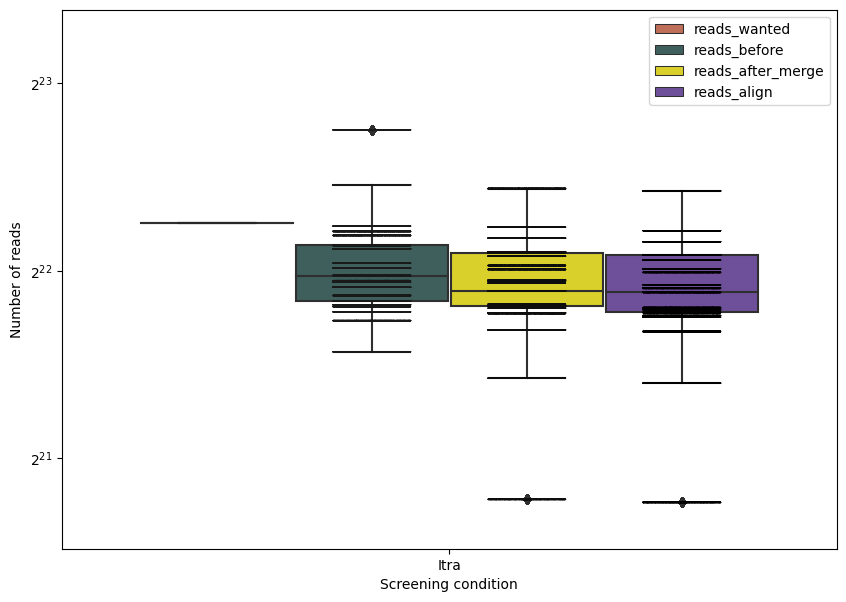

In [12]:
df_melt = pd.melt(df_sum, id_vars=['Antifungal'],value_vars=['reads_wanted', "reads_before",'reads_after_merge',"reads_align"], var_name='Reads control', value_name='Reads')

plt.figure(figsize=(10, 7))
custom_palette = sns.blend_palette(["#CF6448","#386461","#F6EA0E","#6C44A6"], n_colors=4)

ax = sns.boxplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",palette = custom_palette)
ax = sns.stripplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",color="black",dodge=True, jitter=0.2, size=1)

plt.ylim(1500000, 11000000)

plt.yscale('log', base=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4])

plt.xlabel('Screening condition')
plt.ylabel('Number of reads')

plt.show()

In [13]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [14]:
# remove wt, they have a count of 0 as they are not variants

ite = 0

for i in df_sum.iterrows() :
    
    first_row = df_sum.loc[ite]
    
    position = first_row['position']
    codon_wt = wt_dict[position]
    
    if first_row['codon'] == codon_wt :

        df_sum = df_sum.drop(ite)
        
    ite = ite+1   
    
df_sum = df_sum.reset_index()
df_sum

index            Condition  position codon  Timepoint Antifungal  \
0          0  CaERG11_0_Itra_F1_A        55   AAA          0       Itra   
1          1  CaERG11_0_Itra_F1_A        55   AAC          0       Itra   
2          2  CaERG11_0_Itra_F1_A        55   AAG          0       Itra   
3          3  CaERG11_0_Itra_F1_A        55   AAT          0       Itra   
4          4  CaERG11_0_Itra_F1_A        55   ACC          0       Itra   
...      ...                  ...       ...   ...        ...        ...   
47947  48853  CaERG11_2_Itra_F4_C       511   TGT          2       Itra   
47948  48854  CaERG11_2_Itra_F4_C       511   TTA          2       Itra   
47949  48855  CaERG11_2_Itra_F4_C       511   TTC          2       Itra   
47950  48856  CaERG11_2_Itra_F4_C       511   TTG          2       Itra   
47951  48857  CaERG11_2_Itra_F4_C       511   TTT          2       Itra   

      Fragment Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A  0.000000      639.0       5000000       3942291   
1           F1         A  0.000000      538.0       5000000       3942291   
2           F1         A  0.000000      729.0       5000000       3942291   
3           F1         A  0.000000      397.0       5000000       3942291   
4           F1         A  0.000000      371.0       5000000       3942291   
...        ...       ...       ...        ...           ...           ...   
47947       F4         C  2.343466       16.0       5000000       7056590   
47948       F4         C  2.343466       31.0       5000000       7056590   
47949       F4         C  2.343466      156.0       5000000       7056590   
47950       F4         C  2.343466       15.0       5000000       7056590   
47951       F4         C  2.343466      120.0       5000000       7056590   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                3682783            847748      3657126    378654  
1                3682783            847748      3657126    378654  
2                3682783            847748      3657126    378654  
3                3682783            847748      3657126    378654  
4                3682783            847748      3657126    378654  
...                  ...               ...          ...       ...  
47947            1800156            311595      1780118    217865  
47948            1800156            311595      1780118    217865  
47949            1800156            311595      1780118    217865  
47950            1800156            311595      1780118    217865  
47951            1800156            311595      1780118    217865  

[47952 rows x 16 columns]

In [16]:
#Now we summed the lanes we can put more info in the df : reads in log and normalized. 
#You have to add +1 to the number of reads if you want to be able to get the log2

df_sum['nbr_reads_log'] = np.log2(df_sum['nbr_reads']+1)
df_sum['norm_reads'] = ((df_sum['nbr_reads']+1) / df_sum['reads_align'])
df_sum['norm_reads_log'] = np.log2(df_sum['norm_reads'])

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date
df_sum.to_csv(f"c:{name}.csv")  

# 3- Selection coefficient

In [18]:
#open the variants counts with summed lanes

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
df_v = pd.read_csv(name, header=0, index_col = 0)
df_v

index            Condition  position codon  Timepoint Antifungal  \
0          0  CaERG11_0_Itra_F1_A        55   AAA          0       Itra   
1          1  CaERG11_0_Itra_F1_A        55   AAC          0       Itra   
2          2  CaERG11_0_Itra_F1_A        55   AAG          0       Itra   
3          3  CaERG11_0_Itra_F1_A        55   AAT          0       Itra   
4          4  CaERG11_0_Itra_F1_A        55   ACC          0       Itra   
...      ...                  ...       ...   ...        ...        ...   
47947  48853  CaERG11_2_Itra_F4_C       511   TGT          2       Itra   
47948  48854  CaERG11_2_Itra_F4_C       511   TTA          2       Itra   
47949  48855  CaERG11_2_Itra_F4_C       511   TTC          2       Itra   
47950  48856  CaERG11_2_Itra_F4_C       511   TTG          2       Itra   
47951  48857  CaERG11_2_Itra_F4_C       511   TTT          2       Itra   

      Fragment Replicate        OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A  0.000000      639.0       5000000       3942291   
1           F1         A  0.000000      538.0       5000000       3942291   
2           F1         A  0.000000      729.0       5000000       3942291   
3           F1         A  0.000000      397.0       5000000       3942291   
4           F1         A  0.000000      371.0       5000000       3942291   
...        ...       ...       ...        ...           ...           ...   
47947       F4         C  2.343466       16.0       5000000       7056590   
47948       F4         C  2.343466       31.0       5000000       7056590   
47949       F4         C  2.343466      156.0       5000000       7056590   
47950       F4         C  2.343466       15.0       5000000       7056590   
47951       F4         C  2.343466      120.0       5000000       7056590   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  \
0                3682783            847748      3657126    378654   
1                3682783            847748      3657126    378654   
2                3682783            847748      3657126    378654   
3                3682783            847748      3657126    378654   
4                3682783            847748      3657126    378654   
...                  ...               ...          ...       ...   
47947            1800156            311595      1780118    217865   
47948            1800156            311595      1780118    217865   
47949            1800156            311595      1780118    217865   
47950            1800156            311595      1780118    217865   
47951            1800156            311595      1780118    217865   

       nbr_reads_log  norm_reads  norm_reads_log  
0           9.321928    0.000175      -12.480351  
1           9.074141    0.000147      -12.728137  
2           9.511753    0.000200      -12.290526  
3           8.636625    0.000109      -13.165654  
4           8.539159    0.000102      -13.263120  
...              ...         ...             ...  
47947       4.087463    0.000010      -16.676079  
47948       5.000000    0.000018      -15.763541  
47949       7.294621    0.000088      -13.468921  
47950       4.000000    0.000009      -16.763541  
47951       6.918863    0.000068      -13.844678  

[47952 rows x 19 columns]

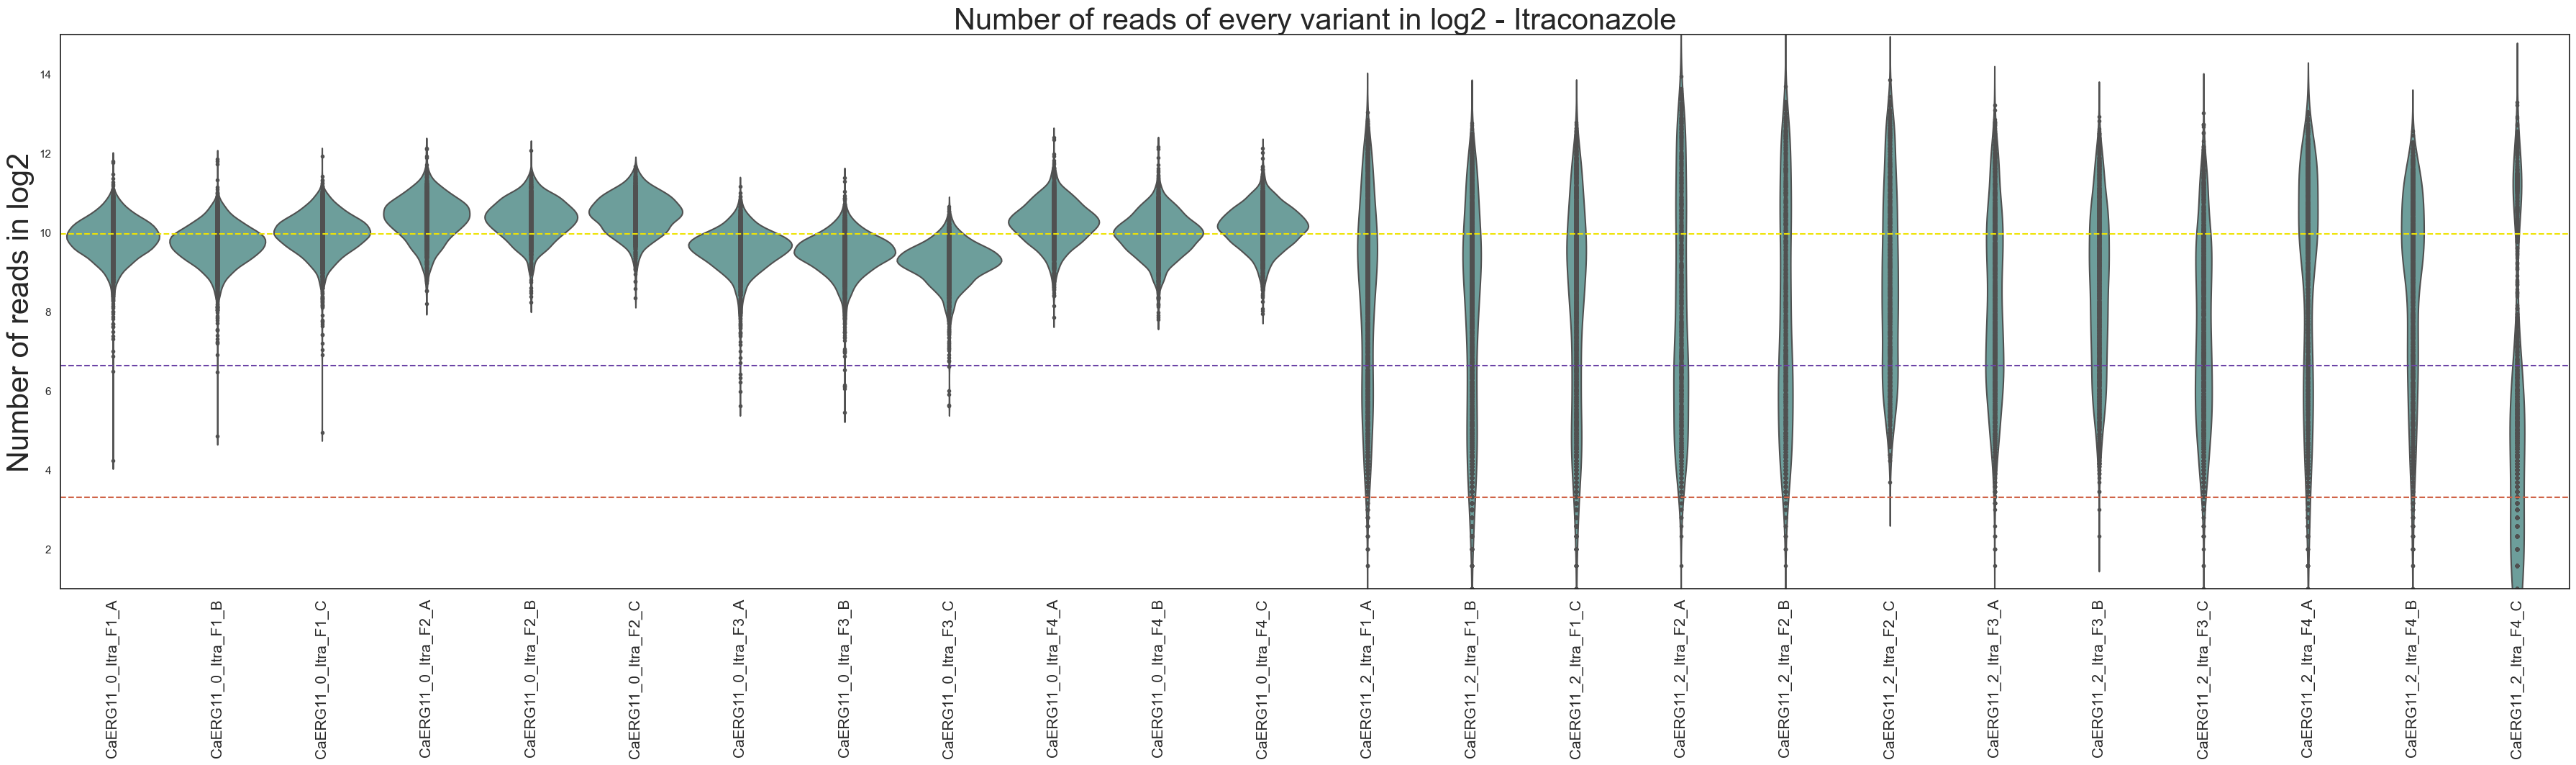

In [19]:

sns.set_style("white")

row = 0
sns.set_theme(style="white", palette=None)
plt.figure(figsize=(45,10))

sns.violinplot(data = df_v, x = 'Condition', y = 'nbr_reads_log',  inner = "point",width=1, color = "#65A6A2")
plt.ylabel("Number of reads in log2",fontsize = 30)
plt.xlabel("")
plt.tick_params(axis="x", labelsize=15, rotation = 90) 
title = condition
plt.title(title, fontsize = 40)
plt.axhline(9.97, color="#EEE304", linestyle="--")
plt.axhline(6.64, color = "#6C44A6", linestyle="--")
plt.axhline(3.32, color = "#D06448", linestyle="--")
plt.ylim(1, 15)


plt.title(f'Number of reads of every variant in log2 - {condition}',y=1, fontsize=30)

name = "./violin_plot_reads_all_log2_lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
plt.savefig(f'{name}.png', transparent=True, dpi=400, bbox_inches='tight')

In [20]:
##remove F4 replicate C as it failed during screening and does not look good in tp2

df_v = df_v.drop(df_v[(df_v['Fragment'] == 'F4') & (df_v['Replicate'] == 'C')].index)

In [21]:
#Get a wide format with reads at every timepoint

#reads norm not in log
df_wide_tp = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"], 
                            columns= "Timepoint", values="norm_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tp=df_wide_tp[colus]

df_wide_tp = df_wide_tp.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tp = df_wide_tp.rename(columns={0: 'freq_tp0', 1 : "freq_tp1",
                                        2 : "freq_tp2", 3 : "freq_tp3"}) #remove 3 if no tp3

df_wide_tp

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2
0                55   AAA       Itra       F1         A  0.000175  0.000021
1                55   AAA       Itra       F1         B  0.000177  0.000013
2                55   AAA       Itra       F1         C  0.000168  0.000017
3                55   AAC       Itra       F1         A  0.000147  0.000018
4                55   AAC       Itra       F1         B  0.000141  0.000015
...             ...   ...        ...      ...       ...       ...       ...
21991           511   TTC       Itra       F4         B  0.000146  0.000220
21992           511   TTG       Itra       F4         A  0.000217  0.000126
21993           511   TTG       Itra       F4         B  0.000200  0.000137
21994           511   TTT       Itra       F4         A  0.000177  0.000286
21995           511   TTT       Itra       F4         B  0.000171  0.000262

[21996 rows x 7 columns]

In [22]:
#df wide with raw nbr reads
df_wide_tpnbr = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="nbr_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tpnbr=df_wide_tpnbr[colus]

df_wide_tpnbr = df_wide_tpnbr.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpnbr = df_wide_tpnbr.rename(columns={0: 'nbr_tp0', 1 : "nbr_tp1",
                                              2 : "nbr_tp2", 3 : "nbr_tp3"}) #remove 3 if no tp3
df_wide_tpnbr

Timepoint  position codon Antifungal Fragment Replicate  nbr_tp0  nbr_tp2
0                55   AAA       Itra       F1         A    639.0     79.0
1                55   AAA       Itra       F1         B    592.0     72.0
2                55   AAA       Itra       F1         C    745.0     76.0
3                55   AAC       Itra       F1         A    538.0     69.0
4                55   AAC       Itra       F1         B    472.0     81.0
...             ...   ...        ...      ...       ...      ...      ...
21991           511   TTC       Itra       F4         B    609.0    781.0
21992           511   TTG       Itra       F4         A   1012.0    613.0
21993           511   TTG       Itra       F4         B    833.0    487.0
21994           511   TTT       Itra       F4         A    823.0   1390.0
21995           511   TTT       Itra       F4         B    711.0    930.0

[21996 rows x 7 columns]

In [23]:
#df wide with OD
df_wide_tpod = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="OD")

colus = df_sum['Timepoint'].unique()
df_wide_tpod=df_wide_tpod[colus]

df_wide_tpod = df_wide_tpod.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpod = df_wide_tpod.rename(columns={0: 'OD_tp0', 1 : "OD_tp1",
                                              2 : "OD_tp2", 3 : "OD_tp3"}) #remove 3 if no tp3
df_wide_tpod

Timepoint  position codon Antifungal Fragment Replicate  OD_tp0    OD_tp2
0                55   AAA       Itra       F1         A     0.0  8.782747
1                55   AAA       Itra       F1         B     0.0  9.388275
2                55   AAA       Itra       F1         C     0.0  9.301153
3                55   AAC       Itra       F1         A     0.0  8.782747
4                55   AAC       Itra       F1         B     0.0  9.388275
...             ...   ...        ...      ...       ...     ...       ...
21991           511   TTC       Itra       F4         B     0.0  7.543326
21992           511   TTG       Itra       F4         A     0.0  9.377983
21993           511   TTG       Itra       F4         B     0.0  7.543326
21994           511   TTT       Itra       F4         A     0.0  9.377983
21995           511   TTT       Itra       F4         B     0.0  7.543326

[21996 rows x 7 columns]

In [24]:
#merge wide with frequencies,raw nbrs of reads and od
merged_df = pd.merge(df_wide_tp, df_wide_tpnbr, on=['position', 'codon', "Antifungal", "Fragment", "Replicate"])

merged_df = pd.merge(merged_df, df_wide_tpod, on=['position', 'codon', "Antifungal", "Fragment", 
                                                    "Replicate"])
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA       Itra       F1         A  0.000175  0.000021   
1                55   AAA       Itra       F1         B  0.000177  0.000013   
2                55   AAA       Itra       F1         C  0.000168  0.000017   
3                55   AAC       Itra       F1         A  0.000147  0.000018   
4                55   AAC       Itra       F1         B  0.000141  0.000015   
...             ...   ...        ...      ...       ...       ...       ...   
21991           511   TTC       Itra       F4         B  0.000146  0.000220   
21992           511   TTG       Itra       F4         A  0.000217  0.000126   
21993           511   TTG       Itra       F4         B  0.000200  0.000137   
21994           511   TTT       Itra       F4         A  0.000177  0.000286   
21995           511   TTT       Itra       F4         B  0.000171  0.000262   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  
0            639.0     79.0     0.0  8.782747  
1            592.0     72.0     0.0  9.388275  
2            745.0     76.0     0.0  9.301153  
3            538.0     69.0     0.0  8.782747  
4            472.0     81.0     0.0  9.388275  
...            ...      ...     ...       ...  
21991        609.0    781.0     0.0  7.543326  
21992       1012.0    613.0     0.0  9.377983  
21993        833.0    487.0     0.0  7.543326  
21994        823.0   1390.0     0.0  9.377983  
21995        711.0    930.0     0.0  7.543326  

[21996 rows x 11 columns]

In [25]:
#log2foldchange calculation

merged_df['log2(tp2/tp0)'] = np.log2((df_wide_tp["freq_tp2"] / df_wide_tp["freq_tp0"]))

 


merged_df = merged_df.rename(columns={'log2(tp2/tp0)': 'l2fc_0_2'})

merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA       Itra       F1         A  0.000175  0.000021   
1                55   AAA       Itra       F1         B  0.000177  0.000013   
2                55   AAA       Itra       F1         C  0.000168  0.000017   
3                55   AAC       Itra       F1         A  0.000147  0.000018   
4                55   AAC       Itra       F1         B  0.000141  0.000015   
...             ...   ...        ...      ...       ...       ...       ...   
21991           511   TTC       Itra       F4         B  0.000146  0.000220   
21992           511   TTG       Itra       F4         A  0.000217  0.000126   
21993           511   TTG       Itra       F4         B  0.000200  0.000137   
21994           511   TTT       Itra       F4         A  0.000177  0.000286   
21995           511   TTT       Itra       F4         B  0.000171  0.000262   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  
0            639.0     79.0     0.0  8.782747 -3.081327  
1            592.0     72.0     0.0  9.388275 -3.771823  
2            745.0     76.0     0.0  9.301153 -3.277821  
3            538.0     69.0     0.0  8.782747 -3.026185  
4            472.0     81.0     0.0  9.388275 -3.277904  
...            ...      ...     ...       ...       ...  
21991        609.0    781.0     0.0  7.543326  0.588738  
21992       1012.0    613.0     0.0  9.377983 -0.781306  
21993        833.0    487.0     0.0  7.543326 -0.542788  
21994        823.0   1390.0     0.0  9.377983  0.696424  
21995        711.0    930.0     0.0  7.543326  0.617282  

[21996 rows x 12 columns]

In [26]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in merged_df.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
merged_df["aa"] = aa_list
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA       Itra       F1         A  0.000175  0.000021   
1                55   AAA       Itra       F1         B  0.000177  0.000013   
2                55   AAA       Itra       F1         C  0.000168  0.000017   
3                55   AAC       Itra       F1         A  0.000147  0.000018   
4                55   AAC       Itra       F1         B  0.000141  0.000015   
...             ...   ...        ...      ...       ...       ...       ...   
21991           511   TTC       Itra       F4         B  0.000146  0.000220   
21992           511   TTG       Itra       F4         A  0.000217  0.000126   
21993           511   TTG       Itra       F4         B  0.000200  0.000137   
21994           511   TTT       Itra       F4         A  0.000177  0.000286   
21995           511   TTT       Itra       F4         B  0.000171  0.000262   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2 aa  
0            639.0     79.0     0.0  8.782747 -3.081327  K  
1            592.0     72.0     0.0  9.388275 -3.771823  K  
2            745.0     76.0     0.0  9.301153 -3.277821  K  
3            538.0     69.0     0.0  8.782747 -3.026185  N  
4            472.0     81.0     0.0  9.388275 -3.277904  N  
...            ...      ...     ...       ...       ... ..  
21991        609.0    781.0     0.0  7.543326  0.588738  F  
21992       1012.0    613.0     0.0  9.377983 -0.781306  L  
21993        833.0    487.0     0.0  7.543326 -0.542788  L  
21994        823.0   1390.0     0.0  9.377983  0.696424  F  
21995        711.0    930.0     0.0  7.543326  0.617282  F  

[21996 rows x 13 columns]

In [27]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [29]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

In [30]:
# get all the wts infos in our df

df_wt = merged_df  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.reset_index()
df_wt  # Outputting the filtered DataFrame

Timepoint  index  position codon Antifungal Fragment Replicate  freq_tp0  \
0             21        55   ATC       Itra       F1         A  0.000131   
1             22        55   ATC       Itra       F1         B  0.000132   
2             23        55   ATC       Itra       F1         C  0.000124   
3             27        55   ATT       Itra       F1         A  0.000190   
4             28        55   ATT       Itra       F1         B  0.000178   
..           ...       ...   ...        ...      ...       ...       ...   
731        21897       510   GTC       Itra       F4         B  0.000218   
732        21988       511   TTA       Itra       F4         A  0.000169   
733        21989       511   TTA       Itra       F4         B  0.000155   
734        21992       511   TTG       Itra       F4         A  0.000217   
735        21993       511   TTG       Itra       F4         B  0.000200   

Timepoint  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2 aa  
0          0.000095    478.0    367.0     0.0  8.782747 -0.461647  I  
1          0.000052    440.0    291.0     0.0  9.388275 -1.344570  I  
2          0.000091    549.0    402.0     0.0  9.301153 -0.450227  I  
3          0.000119    694.0    458.0     0.0  8.782747 -0.679846  I  
4          0.000079    594.0    446.0     0.0  9.388275 -1.162374  I  
..              ...      ...      ...     ...       ...       ... ..  
731        0.000115    907.0    407.0     0.0  7.543326 -0.923745  V  
732        0.000093    788.0    450.0     0.0  9.377983 -0.865880  L  
733        0.000102    646.0    361.0     0.0  7.543326 -0.607398  L  
734        0.000126   1012.0    613.0     0.0  9.377983 -0.781306  L  
735        0.000137    833.0    487.0     0.0  7.543326 -0.542788  L  

[736 rows x 14 columns]

In [31]:
# get all the synonymous wts infos, they are the most representative of wt behaviour as they are in frequencies similar
# to other variants in comparison with wt that is in higher frequency and correspond only to one measure

df_wt_syn = df_wt

ite = 0

for i in df_wt_syn.iterrows() :
    
    first_row = df_wt_syn.loc[ite]
    
    position = first_row['position']
    aa_wt = aa_dict[position]
    codon_wt = wt_dict[position]
    print(first_row['codon'])
    
    if first_row['codon'] == codon_wt :

        df_wt_syn = df_wt_syn.drop(ite)
        print("remove : " + str(position) + codon_wt)
        
    ite = ite+1   
    
df_wt_syn = df_wt_syn.reset_index().drop("index",axis=1).drop("level_0",axis=1)
df_wt_syn

ATC
ATC
ATC
ATT
ATT
ATT
TTT
TTT
TTT
GGA
GGA
GGA
GGT
GGT
GGT
TCC
TCC
TCC
TCT
TCT
TCT
GCC
GCC
GCC
GCT
GCT
GCT
GCC
GCC
GCC
GCT
GCT
GCT
TCC
TCC
TCC
TAC
TAC
TAC
GGA
GGA
GGA
CAG
CAG
CAG
CAG
CAG
CAG
CCA
CCA
CCA
CCT
CCT
CCT
TAC
TAC
TAC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTC
TTA
TTA
TTA
TTG
TTG
TTG
TTA
TTA
TTA
TTG
TTG
TTG
GGA
GGA
GGA
GGT
GGT
GGT
AAG
AAG
AAG
GTC
GTC
GTC
GTT
GTT
GTT
GGA
GGA
GGA
CAT
CAT
CAT
GAG
GAG
GAG
TTC
TTC
TTC
GTT
GTT
GTT
TTT
TTT
TTT
AAC
AAC
AAC
GCC
GCC
GCC
GCT
GCT
GCT
TTG
TTG
TTG
GTT
GTT
GTT
TCC
TCC
TCC
GCC
GCC
GCC
GAG
GAG
GAG
GAC
GAC
GAC
GCC
GCC
GCC
GCT
GCT
GCT
TAT
TAT
TAT
AAG
AAG
AAG
CAT
CAT
CAT
TTG
TTG
TTG
ACC
ACC
ACC
ACT
ACT
ACT
ACC
ACC
ACC
CCA
CCA
CCA
CCT
CCT
CCT
GTC
GTC
GTC
GTT
GTT
GTT
TTT
TTT
TTT
GGT
GGT
GGT
AAA
AAA
AAA
GGT
GGT
GGT
GTC
GTC
GTC
ATT
ATT
ATT
TAT
TAT
TAT
GAC
GAC
GAC
TGC
TGC
TGC
CCA
CCA
CCA
CCT
CCT
CCT
AAT
AAT
AAT
TCC
TCC
TCC
TCT
TCT
TCT
AGA
AGA
AGA
TTA
TTA
TTA
TTG
TTG
TTG
GAA
GAA
GAA
CAA
CAA
CAA
AAG
AAG
AAG
AAA
AAA
AAA
TTC
TTC
TTC
GCC
GCC
GCC
AAG
AAG
AAG
TTT


Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   ATC       Itra       F1         A  0.000131  0.000095   
1                55   ATC       Itra       F1         B  0.000132  0.000052   
2                55   ATC       Itra       F1         C  0.000124  0.000091   
3                55   ATT       Itra       F1         A  0.000190  0.000119   
4                55   ATT       Itra       F1         B  0.000178  0.000079   
..              ...   ...        ...      ...       ...       ...       ...   
731             510   GTC       Itra       F4         B  0.000218  0.000115   
732             511   TTA       Itra       F4         A  0.000169  0.000093   
733             511   TTA       Itra       F4         B  0.000155  0.000102   
734             511   TTG       Itra       F4         A  0.000217  0.000126   
735             511   TTG       Itra       F4         B  0.000200  0.000137   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2 aa  
0            478.0    367.0     0.0  8.782747 -0.461647  I  
1            440.0    291.0     0.0  9.388275 -1.344570  I  
2            549.0    402.0     0.0  9.301153 -0.450227  I  
3            694.0    458.0     0.0  8.782747 -0.679846  I  
4            594.0    446.0     0.0  9.388275 -1.162374  I  
..             ...      ...     ...       ...       ... ..  
731          907.0    407.0     0.0  7.543326 -0.923745  V  
732          788.0    450.0     0.0  9.377983 -0.865880  L  
733          646.0    361.0     0.0  7.543326 -0.607398  L  
734         1012.0    613.0     0.0  9.377983 -0.781306  L  
735          833.0    487.0     0.0  7.543326 -0.542788  L  

[736 rows x 13 columns]

In [32]:
#wt for every fragment and replicate

wt_frag = df_wt_syn.groupby("Fragment")
f1_wt = wt_frag.get_group("F1").reset_index()
f2_wt = wt_frag.get_group("F2").reset_index()
f3_wt = wt_frag.get_group("F3").reset_index()
f4_wt = wt_frag.get_group("F4").reset_index()

wt_frag1_r = f1_wt.groupby("Replicate")
f1_wtA = wt_frag1_r.get_group("A").reset_index()
f1_wtB = wt_frag1_r.get_group("B").reset_index()
f1_wtC = wt_frag1_r.get_group("C").reset_index()

wt_frag2_r = f2_wt.groupby("Replicate")
f2_wtA = wt_frag2_r.get_group("A").reset_index()
f2_wtB = wt_frag2_r.get_group("B").reset_index()
f2_wtC = wt_frag2_r.get_group("C").reset_index()

wt_frag3_r = f3_wt.groupby("Replicate")
f3_wtA = wt_frag3_r.get_group("A").reset_index()
f3_wtB = wt_frag3_r.get_group("B").reset_index()
f3_wtC = wt_frag3_r.get_group("C").reset_index()

wt_frag4_r = f4_wt.groupby("Replicate")
f4_wtA = wt_frag4_r.get_group("A").reset_index()
f4_wtB = wt_frag4_r.get_group("B").reset_index()

merged_df["select_coef"] = np.nan #add an empty column to add our selection coefficient
merged_df_frag = merged_df.groupby("Fragment")

m1 = merged_df_frag.get_group("F1")
m1r = m1.groupby("Replicate")
m1_A = m1r.get_group("A").reset_index()
m1_B = m1r.get_group("B").reset_index()
m1_C = m1r.get_group("C").reset_index()

m2 = merged_df_frag.get_group("F2")
m2r = m2.groupby("Replicate")
m2_A = m2r.get_group("A").reset_index()
m2_B = m2r.get_group("B").reset_index()
m2_C = m2r.get_group("C").reset_index()

m3 = merged_df_frag.get_group("F3")
m3r = m3.groupby("Replicate")
m3_A = m3r.get_group("A").reset_index()
m3_B = m3r.get_group("B").reset_index()
m3_C = m3r.get_group("C").reset_index()

m4 = merged_df_frag.get_group("F4")
m4r = m4.groupby("Replicate")
m4_A = m4r.get_group("A").reset_index()
m4_B = m4r.get_group("B").reset_index()

In [33]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m1_" + str(r)
    df = globals()[name]
    wt_name = "f1_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df1 = pd.concat(df_list, axis=0)

concatenated_df1 

0.00023480275663860002
0.00012895151582859997
0.0001832339887913


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA       Itra       F1         A   
1                1      3        55   AAC       Itra       F1         A   
2                2      6        55   AAG       Itra       F1         A   
3                3      9        55   AAT       Itra       F1         A   
4                4     12        55   ACC       Itra       F1         A   
...            ...    ...       ...   ...        ...      ...       ...   
2832          2832   8930       162   TGT       Itra       F1         C   
2833          2833   8936       162   TTA       Itra       F1         C   
2834          2834   8942       162   TTC       Itra       F1         C   
2835          2835   8948       162   TTG       Itra       F1         C   
2836          2836   8954       162   TTT       Itra       F1         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000175  0.000021    639.0     79.0     0.0  8.782747 -3.081327   
1          0.000147  0.000018    538.0     69.0     0.0  8.782747 -3.026185   
2          0.000200  0.000024    729.0     90.0     0.0  8.782747 -3.085285   
3          0.000109  0.000024    397.0     91.0     0.0  8.782747 -2.194389   
4          0.000102  0.000074    371.0    285.0     0.0  8.782747 -0.460614   
...             ...       ...      ...      ...     ...       ...       ...   
2832       0.000165  0.000076    732.0    336.0     0.0  9.301153 -1.122640   
2833       0.000197  0.000066    873.0    293.0     0.0  9.301153 -1.573392   
2834       0.000206  0.000029    914.0    130.0     0.0  9.301153 -2.805780   
2835       0.000196  0.000063    871.0    277.0     0.0  9.301153 -1.650819   
2836       0.000228  0.000044   1012.0    193.0     0.0  9.301153 -2.386081   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.326392  8.782747  
1          N    -0.320113  8.782747  
2          K    -0.326842  8.782747  
3          N    -0.225405  8.782747  
4          T    -0.027999  8.782747  
...       ..          ...       ...  
2832       C    -0.078427  9.301153  
2833       L    -0.126889  9.301153  
2834       F    -0.259388  9.301153  
2835       L    -0.135214  9.301153  
2836       F    -0.214264  9.301153  

[8511 rows x 17 columns]

In [34]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m2_" + str(r)
    df = globals()[name]
    wt_name = "f2_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df2 = pd.concat(df_list, axis=0)

concatenated_df2 

0.00039205869140255
0.0003872876145615
0.00040568267420785


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0   8067       154   AAA       Itra       F2         A   
1                1   8073       154   AAC       Itra       F2         A   
2                2   8079       154   AAG       Itra       F2         A   
3                3   8085       154   AAT       Itra       F2         A   
4                4   8091       154   ACC       Itra       F2         A   
...            ...    ...       ...   ...        ...      ...       ...   
1151          1151  12287       280   TGT       Itra       F2         C   
1152          1152  12293       280   TTA       Itra       F2         C   
1153          1153  12299       280   TTC       Itra       F2         C   
1154          1154  12305       280   TTG       Itra       F2         C   
1155          1155  12311       280   TTT       Itra       F2         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000216  0.001195    851.0   4692.0     0.0  8.763774  2.465216   
1          0.000219  0.000087    860.0    341.0     0.0  8.763774 -1.328386   
2          0.000237  0.001436    933.0   5637.0     0.0  8.763774  2.597320   
3          0.000133  0.000049    524.0    192.0     0.0  8.763774 -1.440085   
4          0.000262  0.000087   1030.0    342.0     0.0  8.763774 -1.584133   
...             ...       ...      ...      ...     ...       ...       ...   
1151       0.000390  0.000072   1401.0    284.0     0.0  7.129384 -2.445866   
1152       0.000196  0.000234    704.0    931.0     0.0  7.129384  0.255293   
1153       0.000249  0.000112    895.0    444.0     0.0  7.129384 -1.157107   
1154       0.000242  0.000349    868.0   1387.0     0.0  7.129384  0.528166   
1155       0.000225  0.000107    807.0    423.0     0.0  7.129384 -1.077705   

Timepoint aa  select_coef   nbr_gen  
0          K     0.245333  8.763774  
1          N    -0.187540  8.763774  
2          K     0.260407  8.763774  
3          N    -0.200285  8.763774  
4          T    -0.216722  8.763774  
...       ..          ...       ...  
1151       C    -0.357936  7.129384  
1152       L     0.020941  7.129384  
1153       F    -0.177169  7.129384  
1154       L     0.059215  7.129384  
1155       F    -0.166032  7.129384  

[3468 rows x 17 columns]

In [35]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m3_" + str(r)
    df = globals()[name]
    wt_name = "f3_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df3 = pd.concat(df_list, axis=0)

concatenated_df3 

0.00027404535897875004
0.00027887284095630004
0.0002158979121142


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  11646       276   AAA       Itra       F3         A   
1                1  11652       276   AAC       Itra       F3         A   
2                2  11658       276   AAG       Itra       F3         A   
3                3  11664       276   AAT       Itra       F3         A   
4                4  11670       276   ACC       Itra       F3         A   
...            ...    ...       ...   ...        ...      ...       ...   
2014          2014  18461       406   TGT       Itra       F3         C   
2015          2015  18466       406   TTA       Itra       F3         C   
2016          2016  18471       406   TTC       Itra       F3         C   
2017          2017  18476       406   TTG       Itra       F3         C   
2018          2018  18481       406   TTT       Itra       F3         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000207  0.000898    754.0   3914.0     0.0  8.314336  2.113870   
1          0.000151  0.000631    547.0   2750.0     0.0  8.314336  2.067114   
2          0.000215  0.000873    781.0   3806.0     0.0  8.314336  2.022820   
3          0.000260  0.000924    947.0   4027.0     0.0  8.314336  1.826511   
4          0.000220  0.000631    799.0   2752.0     0.0  8.314336  1.522339   
...             ...       ...      ...      ...     ...       ...       ...   
2014       0.000155  0.000162    429.0    588.0     0.0  8.087230  0.062113   
2015       0.000259  0.000321    716.0   1163.0     0.0  8.087230  0.307228   
2016       0.000126  0.000152    348.0    552.0     0.0  8.087230  0.272234   
2017       0.000266  0.000293    734.0   1063.0     0.0  8.087230  0.141864   
2018       0.000232  0.000258    642.0    935.0     0.0  8.087230  0.149871   

Timepoint aa  select_coef   nbr_gen  
0          K     0.222343  8.314336  
1          N     0.216720  8.314336  
2          K     0.211392  8.314336  
3          N     0.187781  8.314336  
4          T     0.151197  8.314336  
...       ..          ...       ...  
2014       C     0.027010  8.087230  
2015       L     0.057319  8.087230  
2016       F     0.052992  8.087230  
2017       L     0.036871  8.087230  
2018       F     0.037862  8.087230  

[6057 rows x 17 columns]

In [36]:
rep_list = ["A","B"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m4_" + str(r)
    df = globals()[name]
    wt_name = "f4_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"] 
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df4 = pd.concat(df_list, axis=0)

concatenated_df4 

0.0001806400376916
0.00021091972828805


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  17367       401   AAA       Itra       F4         A   
1                1  17372       401   AAC       Itra       F4         A   
2                2  17377       401   AAG       Itra       F4         A   
3                3  17382       401   AAT       Itra       F4         A   
4                4  17387       401   ACC       Itra       F4         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  21987       511   TGT       Itra       F4         B   
1976          1976  21989       511   TTA       Itra       F4         B   
1977          1977  21991       511   TTC       Itra       F4         B   
1978          1978  21993       511   TTG       Itra       F4         B   
1979          1979  21995       511   TTT       Itra       F4         B   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000220  0.000004   1027.0     19.0     0.0  9.377983 -5.742679   
1          0.000422  0.000034   1970.0    164.0     0.0  9.377983 -3.637372   
2          0.000278  0.000005   1294.0     23.0     0.0  9.377983 -5.812756   
3          0.000208  0.000010    969.0     47.0     0.0  9.377983 -4.395861   
4          0.000267  0.000017   1244.0     81.0     0.0  9.377983 -3.983361   
...             ...       ...      ...      ...     ...       ...       ...   
1975       0.000206  0.000243    858.0    862.0     0.0  7.543326  0.237081   
1976       0.000155  0.000102    646.0    361.0     0.0  7.543326 -0.607398   
1977       0.000146  0.000220    609.0    781.0     0.0  7.543326  0.588738   
1978       0.000200  0.000137    833.0    487.0     0.0  7.543326 -0.542788   
1979       0.000171  0.000262    711.0    930.0     0.0  7.543326  0.617282   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.546581  9.377983  
1          N    -0.322086  9.377983  
2          K    -0.554053  9.377983  
3          N    -0.402966  9.377983  
4          T    -0.358980  9.377983  
...       ..          ...       ...  
1975       C     0.070706  7.543326  
1976       L    -0.041244  7.543326  
1977       F     0.117324  7.543326  
1978       L    -0.032679  7.543326  
1979       F     0.121109  7.543326  

[3960 rows x 17 columns]

In [37]:
###### save the df
F1_2_long = pd.concat([concatenated_df1 ,concatenated_df2 ],axis=0)
F3_4_long = pd.concat([concatenated_df3 , concatenated_df4 ],axis=0)
All_concat = pd.concat([F1_2_long, F3_4_long],axis=0)
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date
All_concat.to_csv(f"c:{name}.csv")  

All_concat

Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA       Itra       F1         A   
1                1      3        55   AAC       Itra       F1         A   
2                2      6        55   AAG       Itra       F1         A   
3                3      9        55   AAT       Itra       F1         A   
4                4     12        55   ACC       Itra       F1         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  21987       511   TGT       Itra       F4         B   
1976          1976  21989       511   TTA       Itra       F4         B   
1977          1977  21991       511   TTC       Itra       F4         B   
1978          1978  21993       511   TTG       Itra       F4         B   
1979          1979  21995       511   TTT       Itra       F4         B   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000175  0.000021    639.0     79.0     0.0  8.782747 -3.081327   
1          0.000147  0.000018    538.0     69.0     0.0  8.782747 -3.026185   
2          0.000200  0.000024    729.0     90.0     0.0  8.782747 -3.085285   
3          0.000109  0.000024    397.0     91.0     0.0  8.782747 -2.194389   
4          0.000102  0.000074    371.0    285.0     0.0  8.782747 -0.460614   
...             ...       ...      ...      ...     ...       ...       ...   
1975       0.000206  0.000243    858.0    862.0     0.0  7.543326  0.237081   
1976       0.000155  0.000102    646.0    361.0     0.0  7.543326 -0.607398   
1977       0.000146  0.000220    609.0    781.0     0.0  7.543326  0.588738   
1978       0.000200  0.000137    833.0    487.0     0.0  7.543326 -0.542788   
1979       0.000171  0.000262    711.0    930.0     0.0  7.543326  0.617282   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.326392  8.782747  
1          N    -0.320113  8.782747  
2          K    -0.326842  8.782747  
3          N    -0.225405  8.782747  
4          T    -0.027999  8.782747  
...       ..          ...       ...  
1975       C     0.070706  7.543326  
1976       L    -0.041244  7.543326  
1977       F     0.117324  7.543326  
1978       L    -0.032679  7.543326  
1979       F     0.121109  7.543326  

[21996 rows x 17 columns]

# 4- Control between replicates

In [38]:
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"
df_r = pd.read_csv(name, header=0, index_col = 0)
df_r = df_r.drop("level_0",axis=1).drop("index",axis=1)

<Axes:xlabel='Replicate', ylabel='Replicate'>

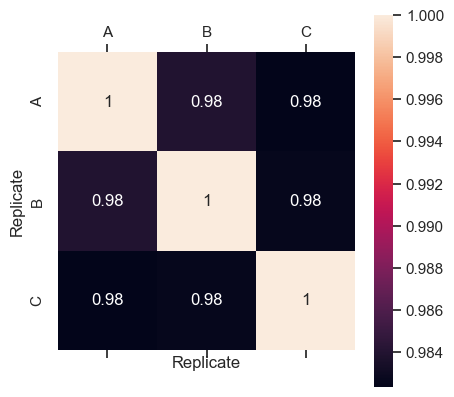

In [39]:
#Correlation condition 1

df_corr = pd.pivot_table(df_r, index=["position","codon","Fragment"], columns= "Replicate", values="select_coef")

colus2 = df_r['Replicate'].unique()
df_corr=df_corr[colus2]

plt.matshow(df_corr.corr())
corr_mat = df_corr.corr()
sns.heatmap(corr_mat, annot=True)

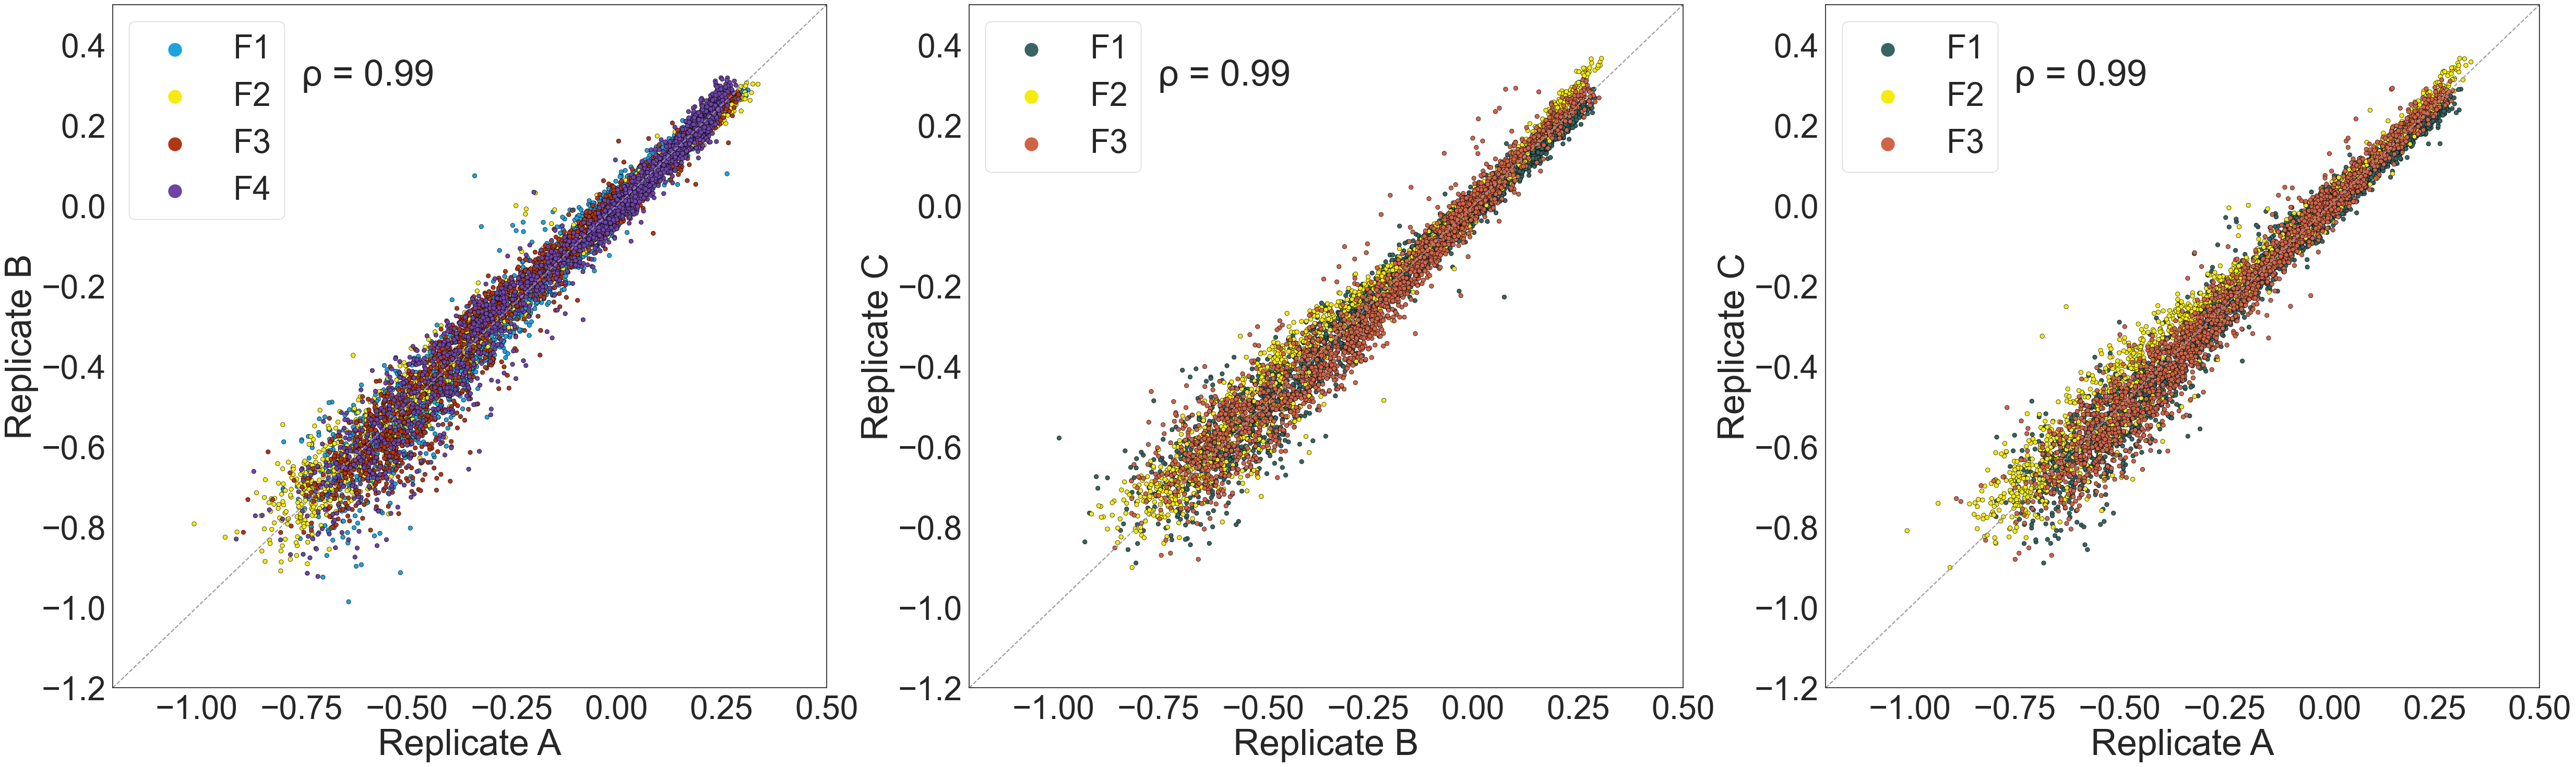

In [40]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")


r_list = ["A","B","A"]


r2_list = ["B","C","C"]

F_list = ["F1","F2","F3","F4"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(3) :    
    
    sns.set_theme(style="white")
    
    colors = ["#1DA3DE","#F6EA0E","#B03616","#6C44A6"]
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
    rep1 = df_r_g.get_group(r_list[i]).reset_index()
    rep2 = df_r_g.get_group(r2_list[i]).reset_index()
    
    if r2_list[i] == "C" :
        rep1 = rep1[rep1['Fragment'] != 'F4'].reset_index()
        colors = ["#386461","#F6EA0E","#CF6448"]
        custom_palette = sns.set_palette(sns.color_palette(colors))
    
    sns.scatterplot(x=rep1["select_coef"],  y=rep2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = rep2["Fragment"],ax = axes[row])
    
    axes[row].set_ylabel("Replicate " + str(r2_list[i]), fontsize=50)
    axes[row].set_xlabel("Replicate " + str(r_list[i]), fontsize=50)
    
    #title = "Replicate " + str(r_list[i]) + " - Replicate " + str(r2_list[i])
    #axes[row].set_title(title, fontsize=45)
    
    axes[row].set_ylim(-1.2, 0.5)
    axes[row].set_xlim(-1.2, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-1.2, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
    
    result = sp.stats.spearmanr(rep1["select_coef"],rep2["select_coef"])
    coeff = result[0]
    p_value = "{:.1e}".format(result[1])
    R2 = coeff**2     
    
    text = "ρ = " + str(round(coeff,2))
    #+ "\np-value = "  + str(p_value)
    axes[row].text(-0.75,0.3, text , fontsize = 50)

        
    row +=1
    
fig.subplots_adjust(hspace=0.31)
#fig.suptitle('Correlation between the Selection coefficient of replicates - ' + condition, y=0.95, fontsize=50)

plt.rcParams['svg.fonttype'] = 'none'
name = "Regression_replicate_select_coeff_" + condition + "_" + experiment + "_" + date
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [41]:
#Get the median of the replicates

df_group = df_r.groupby(["position","codon","Antifungal","Fragment","aa"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","nbr_gen","select_coef"]
df_med = df_group[cols].median()

#reset index so the index becomes columns again
df_med = df_med.reset_index(level=["position","codon","Antifungal","Fragment","aa"])

name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_med.to_csv(name)  
df_med

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA       Itra       F1  K  0.000175  0.000017 -3.277821   
1           55   AAC       Itra       F1  N  0.000141  0.000015 -3.277904   
2           55   AAG       Itra       F1  K  0.000200  0.000017 -3.471191   
3           55   AAT       Itra       F1  N  0.000114  0.000016 -2.814644   
4           55   ACC       Itra       F1  T  0.000099  0.000062 -0.570713   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT       Itra       F4  C  0.000235  0.000233 -0.000336   
7988       511   TTA       Itra       F4  L  0.000162  0.000097 -0.736639   
7989       511   TTC       Itra       F4  F  0.000144  0.000239  0.722301   
7990       511   TTG       Itra       F4  L  0.000209  0.000132 -0.662047   
7991       511   TTT       Itra       F4  F  0.000174  0.000274  0.656853   

      nbr_tp0  nbr_tp2   nbr_gen  select_coef  
0       639.0     76.0  9.301153    -0.310138  
1       538.0     69.0  9.301153    -0.314549  
2       729.0     76.0  9.301153    -0.330928  
3       397.0     71.0  9.301153    -0.237209  
4       371.0    274.0  9.301153    -0.027999  
...       ...      ...       ...          ...  
7987   1042.0    972.5  8.460654     0.055565  
7988    717.0    405.5  8.460654    -0.033899  
7989    635.5   1015.0  8.460654     0.137182  
7990    922.5    550.0  8.460654    -0.025108  
7991    767.0   1160.0  8.460654     0.130573  

[7992 rows x 12 columns]

# 5- Control between codons

In [44]:
name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_c = pd.read_csv(name, header=0, index_col = 0)
df_c

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA       Itra       F1  K  0.000175  0.000017 -3.277821   
1           55   AAC       Itra       F1  N  0.000141  0.000015 -3.277904   
2           55   AAG       Itra       F1  K  0.000200  0.000017 -3.471191   
3           55   AAT       Itra       F1  N  0.000114  0.000016 -2.814644   
4           55   ACC       Itra       F1  T  0.000099  0.000062 -0.570713   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT       Itra       F4  C  0.000235  0.000233 -0.000336   
7988       511   TTA       Itra       F4  L  0.000162  0.000097 -0.736639   
7989       511   TTC       Itra       F4  F  0.000144  0.000239  0.722301   
7990       511   TTG       Itra       F4  L  0.000209  0.000132 -0.662047   
7991       511   TTT       Itra       F4  F  0.000174  0.000274  0.656853   

      nbr_tp0  nbr_tp2   nbr_gen  select_coef  
0       639.0     76.0  9.301153    -0.310138  
1       538.0     69.0  9.301153    -0.314549  
2       729.0     76.0  9.301153    -0.330928  
3       397.0     71.0  9.301153    -0.237209  
4       371.0    274.0  9.301153    -0.027999  
...       ...      ...       ...          ...  
7987   1042.0    972.5  8.460654     0.055565  
7988    717.0    405.5  8.460654    -0.033899  
7989    635.5   1015.0  8.460654     0.137182  
7990    922.5    550.0  8.460654    -0.025108  
7991    767.0   1160.0  8.460654     0.130573  

[7992 rows x 12 columns]

In [45]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in df_c.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
df_c["aa"] = aa_list

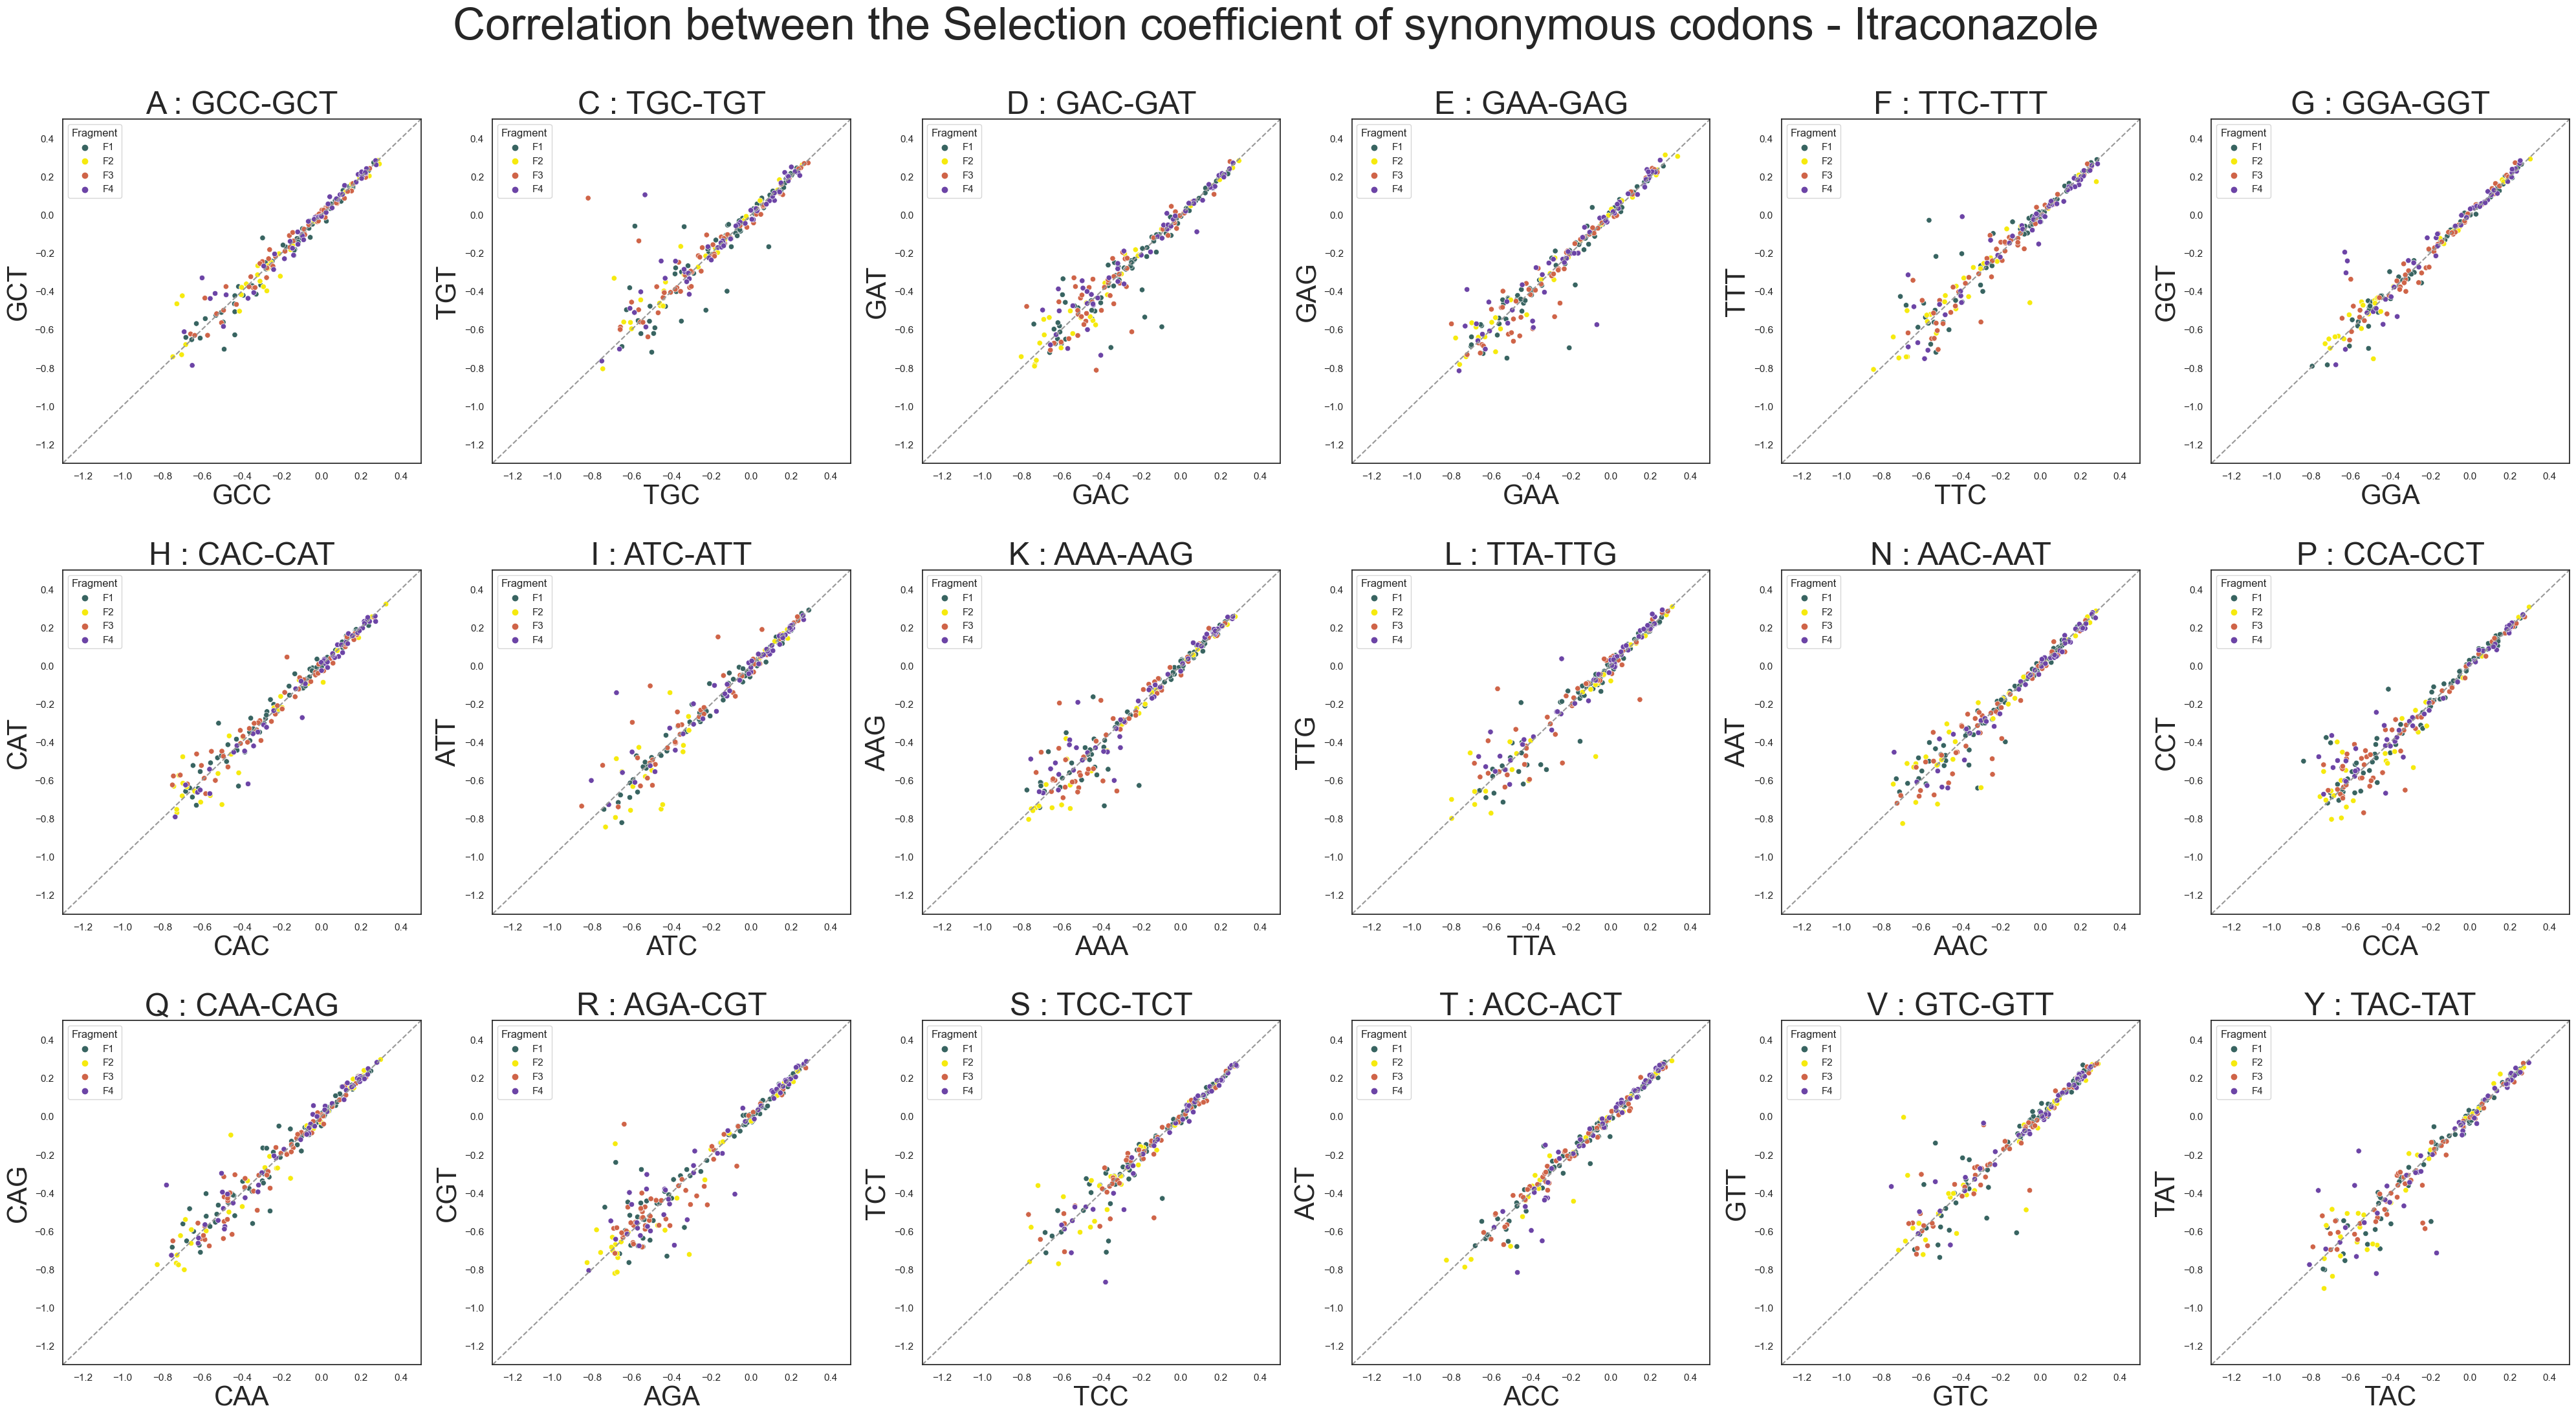

In [46]:
df_co = df_c

# remove wt as they often have only one codon

ite = 0  # Initializing a counter variable

for i in df_co.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_co.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] == aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_co = df_co.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable

df_cod = df_co.groupby(["codon"])
df_aa = df_co.groupby(["aa"])

syn_list = ["A","C","D","E","F","G","H","I","K","L","N","P","Q","R","S","T","V",'Y']

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(3, 6, figsize=(50,25))
axes = axes.flatten()
    
for aa in syn_list :
    
    sns.set_theme(style="white")
    
    colors = ["#386461","#F6EA0E","#CF6448","#6C44A6"]
    sns.set_palette(sns.color_palette(colors))
    
    amac = df_aa.get_group(aa)
    
    codons = amac['codon'].unique()
    
    cod1 = codons[0]
    cod2 = codons[1]

    cod_df = amac.groupby("codon")
    
    codon1 = cod_df.get_group(cod1).reset_index()
    codon2 = cod_df.get_group(cod2).reset_index()
    
    sns.scatterplot(x = codon1["select_coef"], y = codon2["select_coef"], legend = True, hue = codon1["Fragment"],ax = axes[row])
    axes[row].set_ylabel(cod2, fontsize=30)
    axes[row].set_xlabel(cod1, fontsize=30)
    title = aa + " : " + cod1 + "-" + cod2
    axes[row].set_title(title, fontsize=35)
    axes[row].set_ylim(-1.3, 0.5)
    axes[row].set_xlim(-1.3, 0.5)
    
    x_vals = np.array([-1.3, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")

    row +=1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Correlation between the Selection coefficient of synonymous codons - ' + condition, y=0.95, fontsize=50)

name = "Correlation_between_synonymous_codons_" + "select_coeff_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [47]:
# get the mean of every codon

df_group = df_c.groupby(["position","aa","Antifungal","Fragment"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal","Fragment"])

name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name)  

# 6- Control between overlaps

#### We want to verify if the correlation between our overlap is good to see if our results are reproducible and constant.

In [48]:
name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_o = pd.read_csv(name, header=0, index_col = 0)

In [49]:
df_o

position aa Antifungal Fragment  freq_tp0  freq_tp2  l2fc_0_2  nbr_tp0  \
0           55  *       Itra       F1  0.000165  0.000010 -4.075156   662.00   
1           55  A       Itra       F1  0.000159  0.000071 -1.077819   590.50   
2           55  C       Itra       F1  0.000181  0.000088 -0.934742   695.00   
3           55  D       Itra       F1  0.000173  0.000006 -4.819163   675.00   
4           55  E       Itra       F1  0.000209  0.000012 -4.072611   775.50   
...        ... ..        ...      ...       ...       ...       ...      ...   
4277       511  S       Itra       F4  0.000184  0.000238  0.374038   815.00   
4278       511  T       Itra       F4  0.000198  0.000084 -1.256849   874.50   
4279       511  V       Itra       F4  0.000141  0.000066 -1.098475   623.75   
4280       511  W       Itra       F4  0.000186  0.000037 -2.397352   822.50   
4281       511  Y       Itra       F4  0.000178  0.000015 -3.794053   788.25   

      nbr_tp2  select_coef  
0       42.00    -0.395863  
1      332.00    -0.066373  
2      382.50    -0.063770  
3       24.50    -0.467865  
4       54.00    -0.393626  
...       ...          ...  
4277  1009.00     0.096441  
4278   344.50    -0.094517  
4279   276.25    -0.077182  
4280   147.50    -0.227904  
4281    56.00    -0.391255  

[4282 rows x 10 columns]

(-0.85, 0.3)

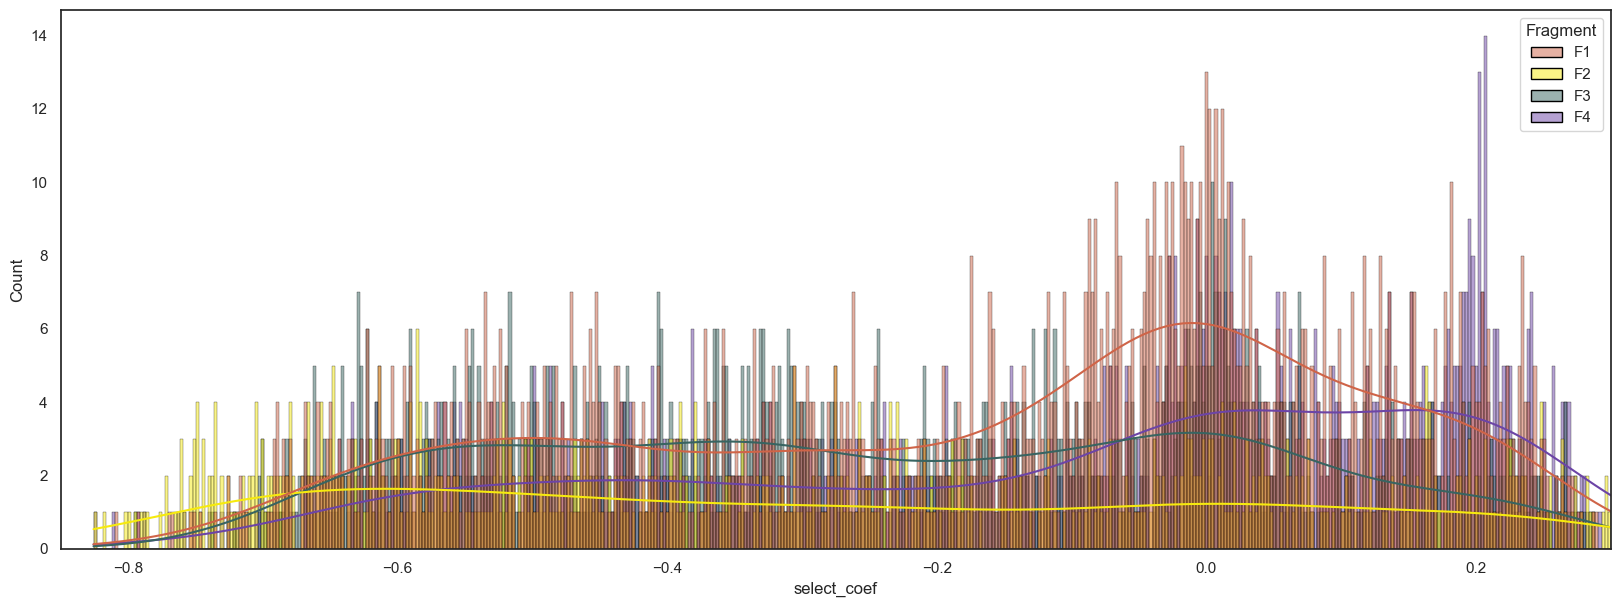

In [50]:
plt.subplots(figsize=(20,7))
custom_palette = sns.blend_palette(["#CF6448","#F6EA0E","#386461","#6C44A6"], n_colors=4)
ax=sns.histplot(data=df_o, x="select_coef", edgecolor="black", hue = "Fragment", kde = True, palette = custom_palette, bins = 500)
ax.set_xlim(-0.85, 0.3)

#name = "distribution_fluco_select_norm_" + experiment + "_" + date + ".png"
#plt.savefig(name, transparent=True, dpi=600, bbox_inches='tight')

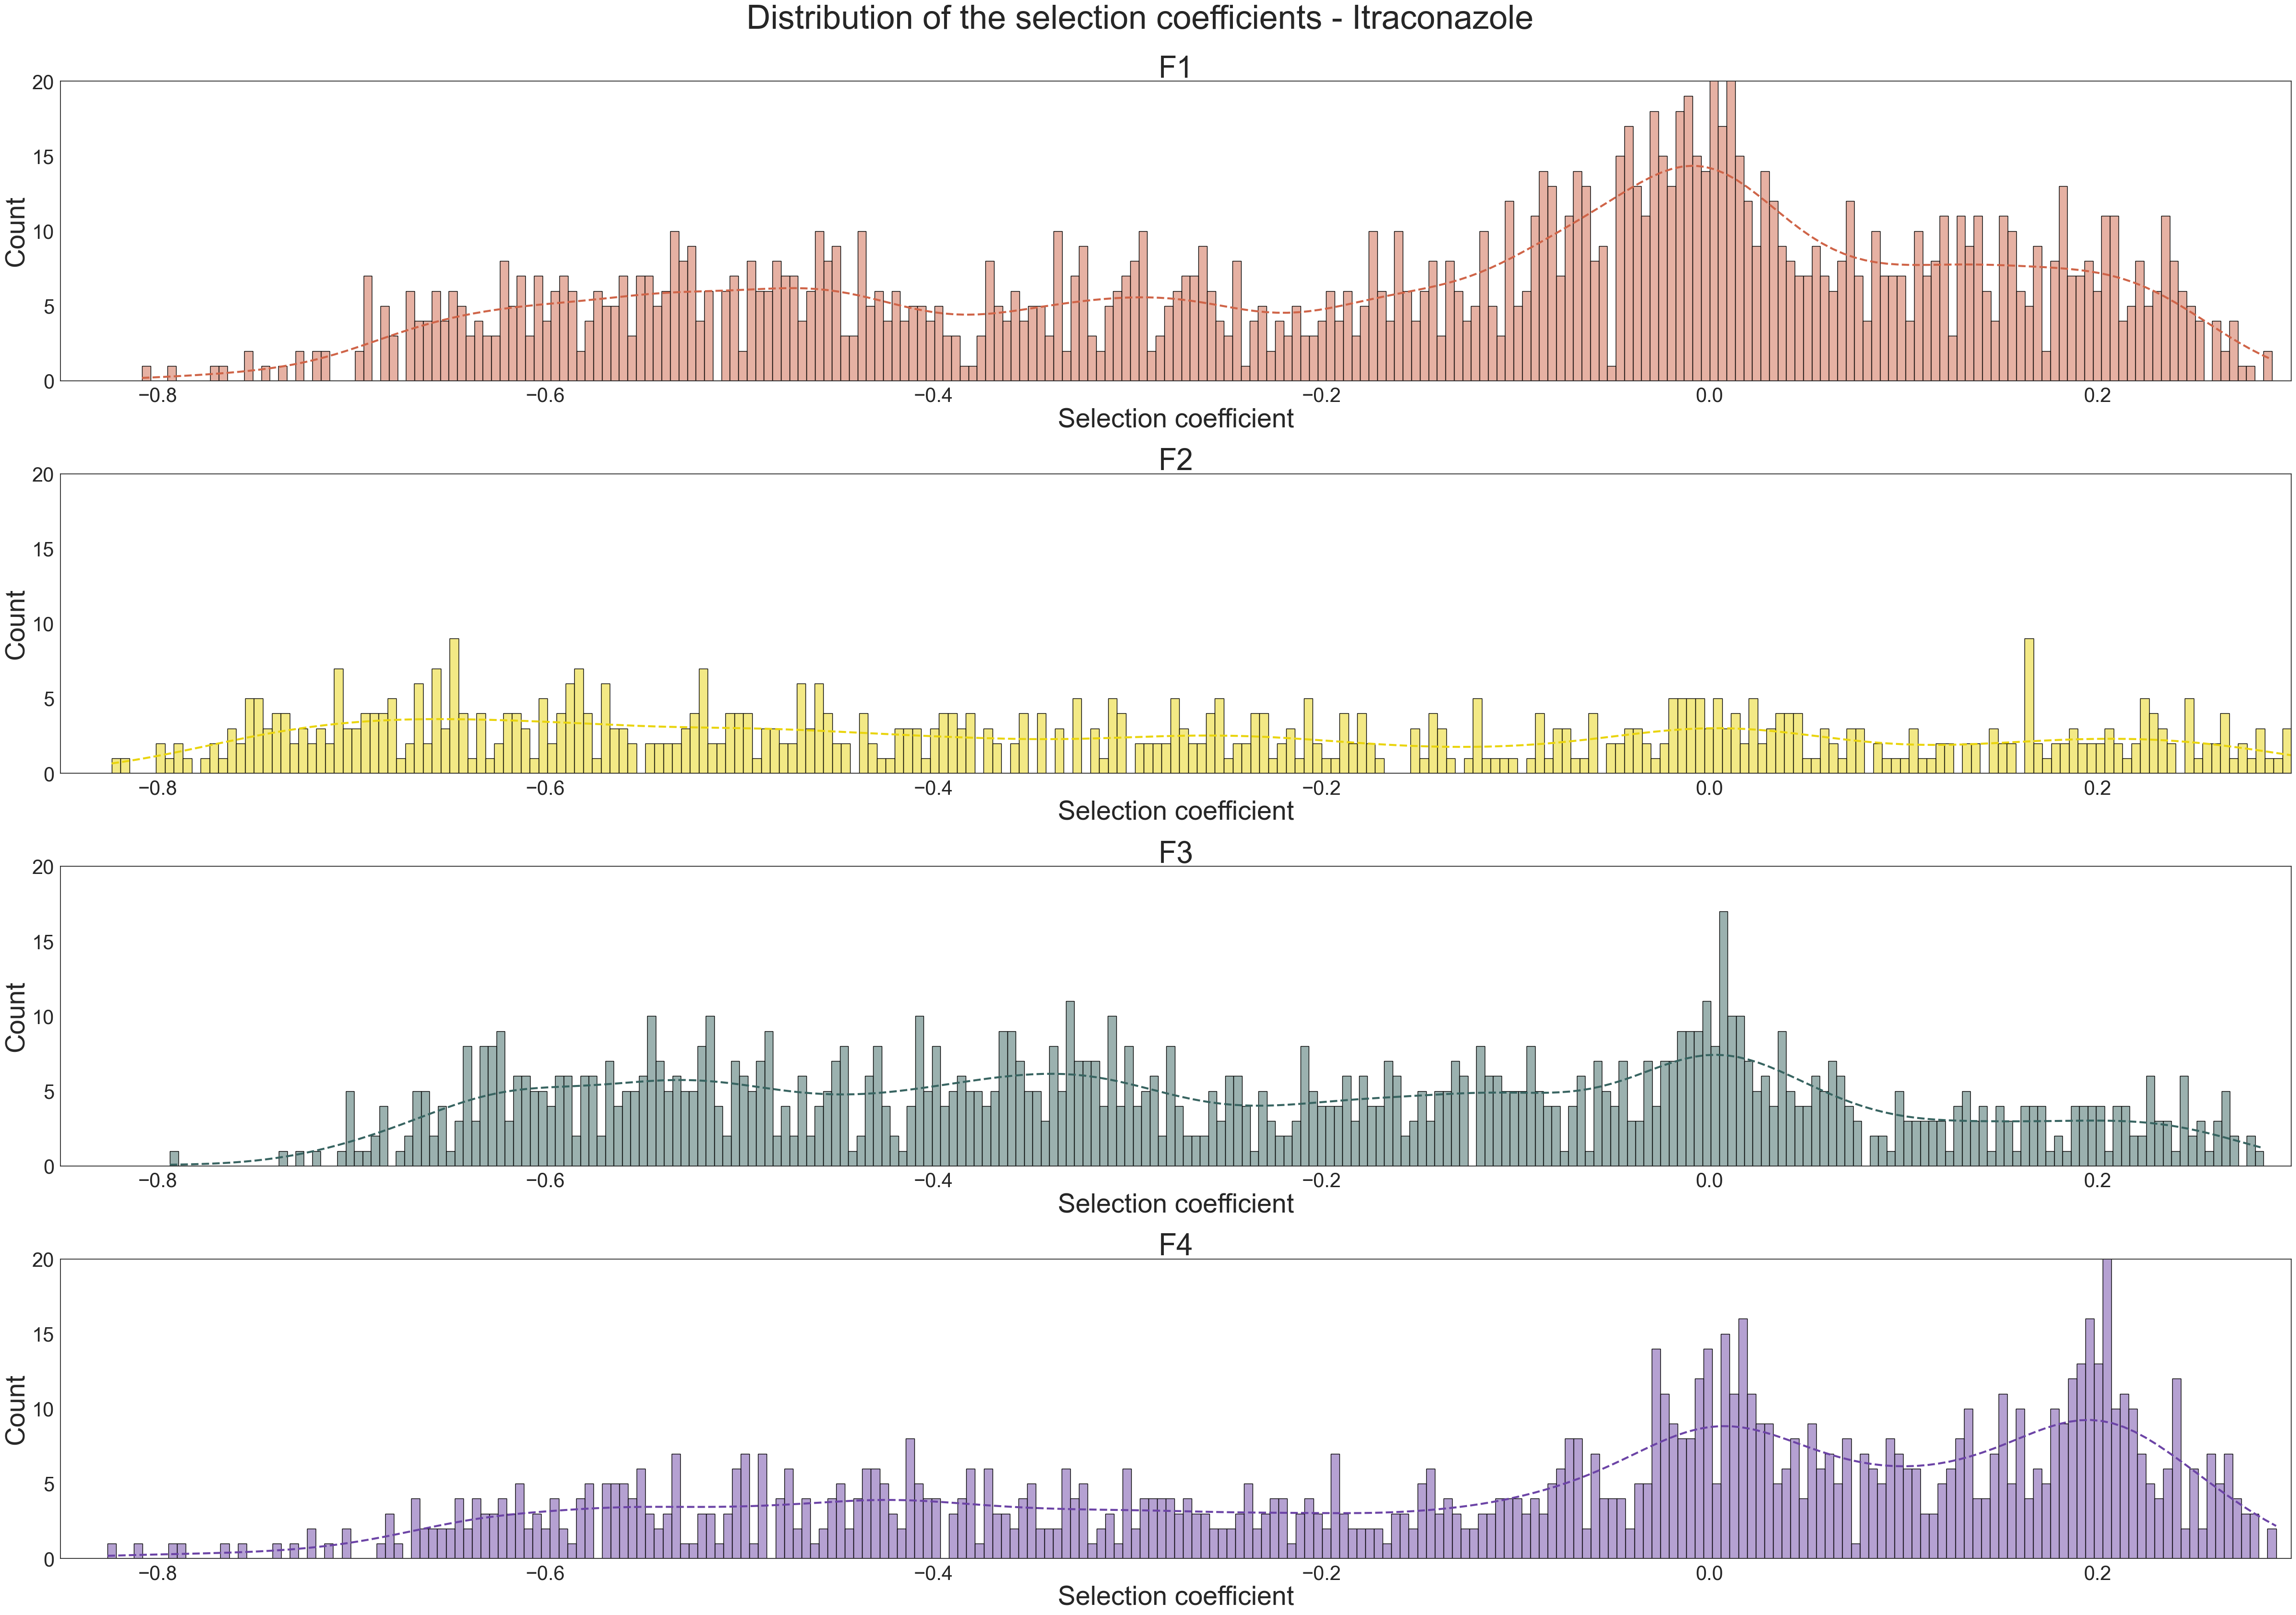

In [51]:
#Distribution of the selection coefficient

df_o_F = df_o.groupby("Fragment")

f_list = ["F1","F2","F3","F4"]
color_list = ["#CF6448","#E9D40D","#386461","#6C44A6"]
row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(4, 1, figsize=(60,40))
axes = axes.flatten()
 
for frag in f_list :
    
    df = df_o_F.get_group(frag)
    
    sns.set_theme(style="white")
    
    sns.histplot(x=df["select_coef"], edgecolor="black", color = color_list[row],  bins = 250,kde=True, kde_kws = {'bw_adjust': 0.5},ax = axes[row], 
                 line_kws = {'linestyle':'dashed','linewidth':'3'}).lines[0].set_color(color_list[row])

    axes[row].set_ylim(0, 20)
    axes[row].set_xlim(-0.85, 0.3)
    
    axes[row].set_ylabel("Count",fontsize=40)
    axes[row].set_xlabel("Selection coefficient",fontsize=40)
    
    axes[row].set_title(frag, fontsize=45)
    
    axes[row].tick_params(labelsize = 30)  
    
    row += 1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Distribution of the selection coefficients - ' + condition, y=0.92, fontsize=50)

name = "Distribution_of_the_selection_coefficient_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [53]:
#put rows in overlaps in a new df

df_new = pd.DataFrame(columns=["index", 'position', 'aa', 'Antifungal', 'Fragment', "l2fc_0_2", "l2fc_0_3", "select_coef", "l2fc_0_2_norm", "l2fc_0_3_norm", "select_coef_norm"])

for _, row in df_o.iterrows():
    position = row['position']
    fragment = row['Fragment']
    
    if position in f3_f4_over and fragment == "F3":
        row['Fragment'] = "F3_4"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F2":
        row['Fragment'] = "F2_3"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F3":
        row['Fragment'] = "F3_2"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f1_f2_over and fragment == "F2":
        row['Fragment'] = "F2_1"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in over_list:
        df_new = df_new.append(row, ignore_index=True)
        
df_new = df_new.reset_index().drop("index",axis=1).drop("level_0",axis=1)

C:\Users\CABED117\AppData\Local\Temp\ipykernel_26040\2685448605.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_26040\2685448605.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_26040\2685448605.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_26040\2685448605.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_

In [55]:
df_group = df_new.groupby(["Fragment"])

f1 = df_group.get_group("F1").reset_index()
f2_1 = df_group.get_group("F2_1").reset_index()
f2_3 = df_group.get_group("F2_3").reset_index()
f3_2 = df_group.get_group("F3_2").reset_index()
f3_4 = df_group.get_group("F3_4").reset_index()
f4 = df_group.get_group("F4").reset_index()

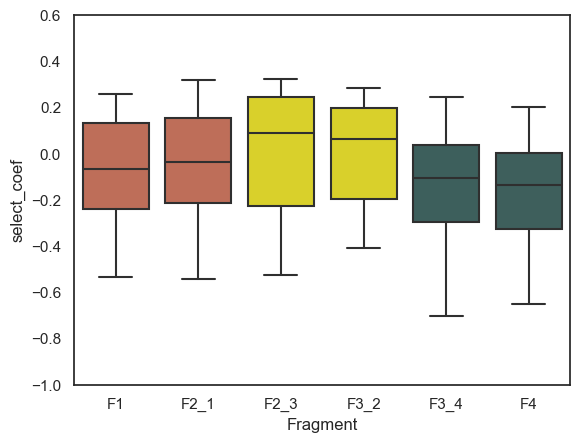

In [56]:
sns.set_theme(style="white")

custom_palette = sns.blend_palette(["#CF6448","#CF6448","#F6EA0E","#F6EA0E","#386461","#386461"], n_colors=6)
sns.boxplot(data= df_new, x= "Fragment", y = "select_coef", palette = custom_palette)
plt.ylim(-1, 0.6)

name = "Boxplot_overlaps_med_select_coef_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

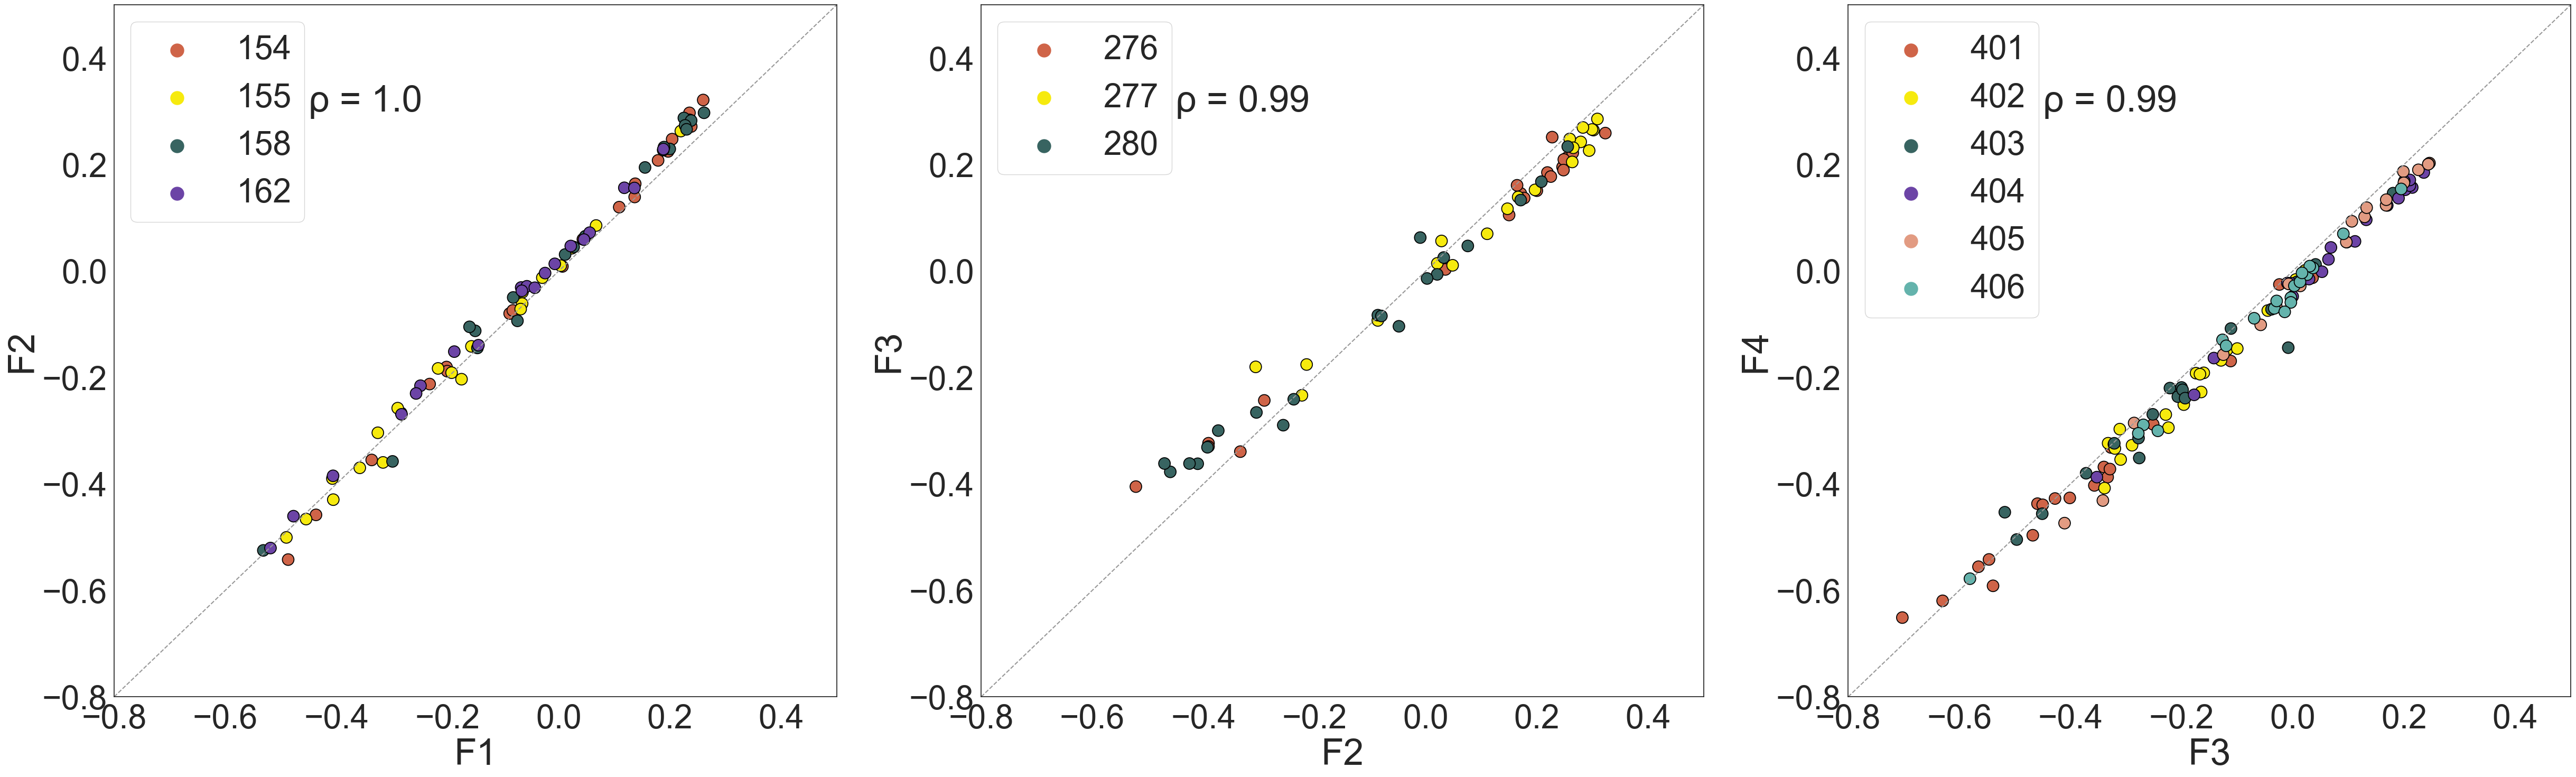

In [57]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")

o1_list = ["f1","f2_3","f3_4"]

o2_list = ["f2_1","f3_2","f4"]

title_name = ["F1 and F2","F2 and F3","F3 and F4"]
x_name = ["F1", "F2", "F3"]
y_name = ["F2", "F3", "F4"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(len(o1_list)) :
    
    name1 = o1_list[i]
    df1 = globals()[name1]
    
    name2 = o2_list[i]
    df2 = globals()[name2]
    
    sns.set_theme(style="white")
    
    custom_palette = sns.color_palette(["#CF6448","#F6EA0E","#386461","#6C44A6","#E29B82","#64B3AC"], n_colors=len(df1["position"].unique()))
    
    sns.scatterplot(x=df1["select_coef"],  y=df2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = df1["position"],s = 250, ax = axes[row])    
    
    axes[row].set_ylabel(y_name[i], fontsize=50)
    axes[row].set_xlabel(x_name[i], fontsize=50)
    
    #axes[row].set_title(title_name[i], fontsize=55)
    
    axes[row].set_ylim(-0.8, 0.5)
    axes[row].set_xlim(-0.8, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-0.8, 0.5])
    y_vals = x_vals
    
    result = sp.stats.spearmanr(df1["select_coef"],df2["select_coef"])
    coeff = result[0]
    p_value = result[1]
    R2 = coeff**2 
    
    text = "ρ = " + str(round(coeff, 2)) #+ "\nP = " + str(round(p_value, 5))
    axes[row].text(-0.45,0.3, text , fontsize = 50)

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)



plt.rcParams['svg.fonttype'] = 'none'
name = "Overlap_select_coef_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [59]:
#Getting the means of the overlapping positions

#norm_df = norm_df.drop('Fragment', axis=1)

df_group = df_o.groupby(["position","aa","Antifungal"])
cols = ["select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal"])

name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name) 

# 7- Heatmaps !!

In [60]:
name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_f = pd.read_csv(name, header=0, index_col = 0)

In [62]:
WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0, index_col = 0)

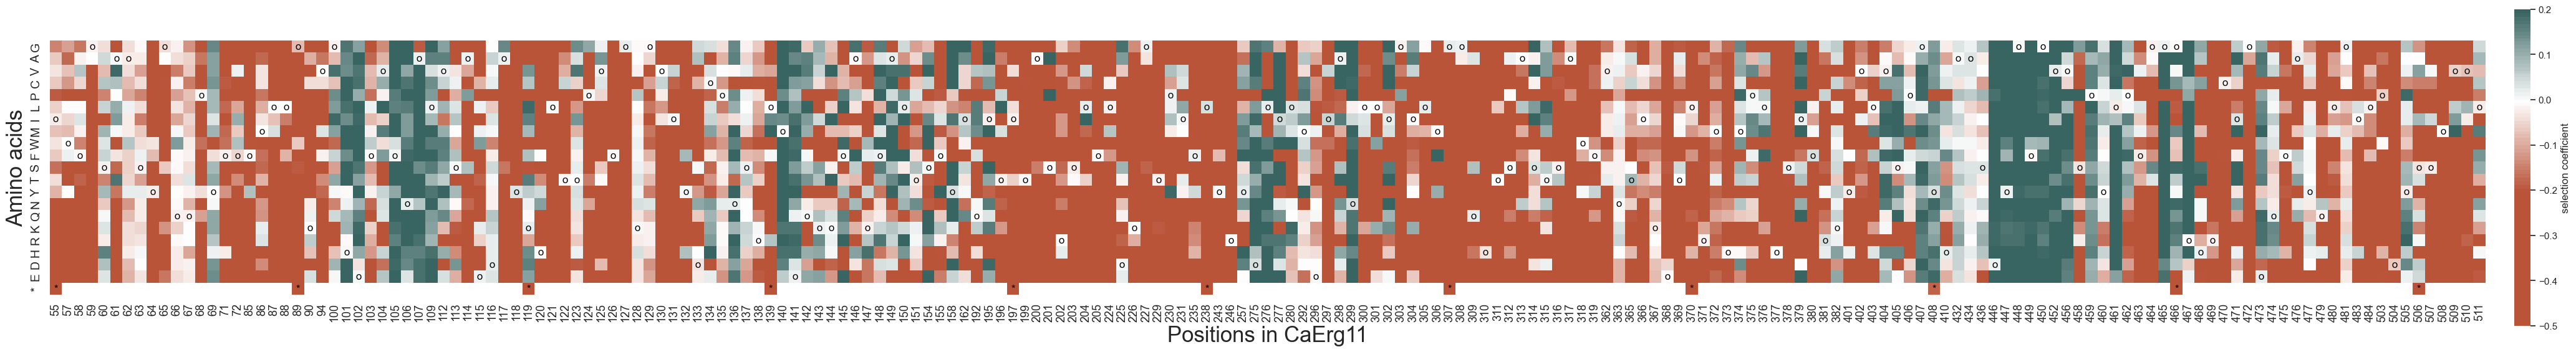

In [63]:
heat = pd.pivot_table(df_f, index="aa", columns= "position", values="select_coef")

heat = heat.reindex(index = ["G","A","V","C","P","L","I","M","W","F","S","T","Y","N","Q","K","R","H","D","E","*"])

custom_palette = sns.blend_palette(["#B95439","#B95439","#B95439","#FFFFFF","#386461"], n_colors=101)

plt.subplots(figsize=(60,60))
sns.set(rc={'figure.facecolor':'white'})
#sns.set(font_scale=1.5)

sns.heatmap(heat, xticklabels="auto", yticklabels=True, annot=False, cmap = custom_palette, 
            robust = True,square=True,  vmin=-0.5, vmax=0.2,center=-0.2, 
            cbar_kws={"shrink": 0.11,"pad": 0.01,'label': 'selection coefficient'})

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=13)

for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if WT_annot.iloc[i, j] == "o" or WT_annot.iloc[i, j] == "*":
            plt.text(j + 0.5, i + 0.5, WT_annot.iloc[i, j], ha='center', va='center', fontsize=12, color='black')
        
#titre = f"Selection coefficients - {condition} Screening - Library Erg11 of " + '$\it{Candida}$' +" "+ '$\it{albicans}$'

#plt.title(titre, fontsize =30)

plt.xlabel('Positions in CaErg11', fontsize = 25)
plt.ylabel('Amino acids', fontsize = 25)

plt.rcParams['svg.fonttype'] = 'none'
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".png"
plt.savefig(name, transparent=True, dpi=750,format='png', bbox_inches='tight')
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".svg"
plt.savefig(name, transparent=True, dpi=300,format='svg', bbox_inches='tight')

# 8- t-test significant resistance

In [64]:
#import the df with the replicates, replicates are needed for t tests
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"

df_t = pd.read_csv(name, header=0)

In [65]:
# Add a new column with the translation
df_t['aa'] = df_t['codon'].map(DNA_Codons)
df_t['DNA_variant'] =df_t['position'].astype(str) + df_t['codon']
df_t['aa_variant'] =df_t['position'].astype(str) + df_t['aa']

In [66]:
Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [67]:
# get all the wts infos in our df fluco

df_wt = df_t  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    else :   
        df_t.loc[ite,"aa_variant"] = "WT"
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.drop("level_0",axis=1).reset_index()

In [68]:
df_wt

level_0  Unnamed: 0  index  position codon Antifungal Fragment Replicate  \
0          7           7     21        55   ATC       Itra       F1         A   
1          9           9     27        55   ATT       Itra       F1         A   
2        112         112    336        58   TTT       Itra       F1         A   
3        136         136    408        59   GGA       Itra       F1         A   
4        137         137    411        59   GGT       Itra       F1         A   
..       ...         ...    ...       ...   ...        ...      ...       ...   
731    21839        1823  21683       507   TCC       Itra       F4         B   
732    21909        1893  21823       509   GTC       Itra       F4         B   
733    21946        1930  21897       510   GTC       Itra       F4         B   
734    21992        1976  21989       511   TTA       Itra       F4         B   
735    21994        1978  21993       511   TTG       Itra       F4         B   

     freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2 aa  \
0    0.000131  0.000095    478.0    367.0     0.0  8.782747 -0.461647  I   
1    0.000190  0.000119    694.0    458.0     0.0  8.782747 -0.679846  I   
2    0.000345  0.000263   1261.0   1015.0     0.0  8.782747 -0.394138  F   
3    0.000211  0.000157    772.0    606.0     0.0  8.782747 -0.430099  G   
4    0.000225  0.000193    821.0    747.0     0.0  8.782747 -0.217427  G   
..        ...       ...      ...      ...     ...       ...       ... ..   
731  0.000235  0.000142    977.0    502.0     0.0  7.543326 -0.728898  S   
732  0.000180  0.000111    750.0    393.0     0.0  7.543326 -0.700239  V   
733  0.000218  0.000115    907.0    407.0     0.0  7.543326 -0.923745  V   
734  0.000155  0.000102    646.0    361.0     0.0  7.543326 -0.607398  L   
735  0.000200  0.000137    833.0    487.0     0.0  7.543326 -0.542788  L   

     select_coef   nbr_gen DNA_variant aa_variant  
0      -0.028116  8.782747       55ATC        55I  
1      -0.052960  8.782747       55ATT        55I  
2      -0.020430  8.782747       58TTT        58F  
3      -0.024524  8.782747       59GGA        59G  
4      -0.000309  8.782747       59GGT        59G  
..           ...       ...         ...        ...  
731    -0.057351  7.543326      507TCC       507S  
732    -0.053552  7.543326      509GTC       509V  
733    -0.083182  7.543326      510GTC       510V  
734    -0.041244  7.543326      511TTA       511L  
735    -0.032679  7.543326      511TTG       511L  

[736 rows x 20 columns]

In [69]:
df_wt["select_coef"].quantile(0.95)

0.04164662871407938

In [70]:
# Perform t-tests for each variant
variants = df_t['aa_variant'].unique()
results = []

for variant in variants:
    variant_data = df_t[df_t['aa_variant'] == variant]

    anti_data = variant_data[variant_data['Antifungal'] == cond]['select_coef']
    wt_data = df_t[df_t['aa_variant'] == 'WT']['select_coef']
    t_stat, p_value = ttest_ind(anti_data, wt_data)
    
    results.append((variant, p_value))

# Apply FDR correction to the p-values decause I am doing multiple comparaison
_, adjusted_p_values, _, _ = multipletests([p_value for _, p_value in results], method='fdr_bh')

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['aa_variant', 'p_value'])
results_df['adjusted_p_value'] = adjusted_p_values

# View the results
print(results_df)

     aa_variant        p_value  adjusted_p_value
0           55K  1.624634e-118     4.593339e-118
1           55N   8.540415e-88      2.003572e-87
2           55T   2.762530e-04      3.151653e-04
3           55R  1.419439e-161     5.346972e-161
4            WT   1.000000e+00      1.000000e+00
...         ...            ...               ...
3826       511Y  1.632802e-114     4.506674e-114
3827       511S   2.604648e-11      3.311784e-11
3828       511C   4.268528e-06      5.036259e-06
3829       511W   7.622275e-28      1.139771e-27
3830       511F   5.787093e-20      8.012416e-20

[3831 rows x 3 columns]


In [71]:
# Merge the variant results 
anti_merged = df_t.merge(results_df, on=['aa_variant'], how='left')

In [72]:
df_group = anti_merged.groupby(["position","Antifungal","aa"])
cols = ["select_coef","p_value","adjusted_p_value"]
med_anti = df_group[cols].median()

#reset index so the index becomes columns again
med_anti = med_anti.reset_index(level=["position","Antifungal","aa"])
med_anti['aa_variant'] =med_anti['position'].astype(str) + med_anti['aa']

In [73]:
advantageous = []
wt_like = []
deleterious = []
df_del = pd.DataFrame(columns=['select_coef', 'aa_variant', 'result'])

for i in range(len(med_anti)):
    if med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] > 0:
        advantageous.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Advantageous"
    elif med_anti.loc[i,"adjusted_p_value"] > 0.01 :
        wt_like.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "WT like"
    elif med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] < 0:
        deleterious.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Deleterious"

In [74]:
print(str(len(advantageous)) + " variant have an advantage")
print(str(len(deleterious)) + " variant have a deleterious substitution")
print(str(len(wt_like)) + " variant are like the WT")

999 variant have an advantage
2477 variant have a deleterious substitution
546 variant are like the WT


In [75]:
df_del_g = df_del.groupby("result")
df_del_wt = df_del_g.get_group("WT like")
#df_del_wt["select_coef"].max()
#df_del_wt["select_coef"].min()
#df_del_wt["select_coef"].quantile(0.95)
df_del_wt["select_coef"].quantile(0.05)

-0.029056215205874814

In [76]:
df_del_wt

select_coef aa_variant   result
8      -0.028803        55I  WT like
25      0.013166        57F  WT like
30     -0.006654        57L  WT like
39     -0.002987        57Y  WT like
40     -0.014105        58A  WT like
...          ...        ...      ...
3989   -0.012296       510I  WT like
3999    -0.07445       510V  WT like
4008    0.008136       511H  WT like
4011   -0.029617       511L  WT like
4015    0.024133       511Q  WT like

[546 rows x 3 columns]

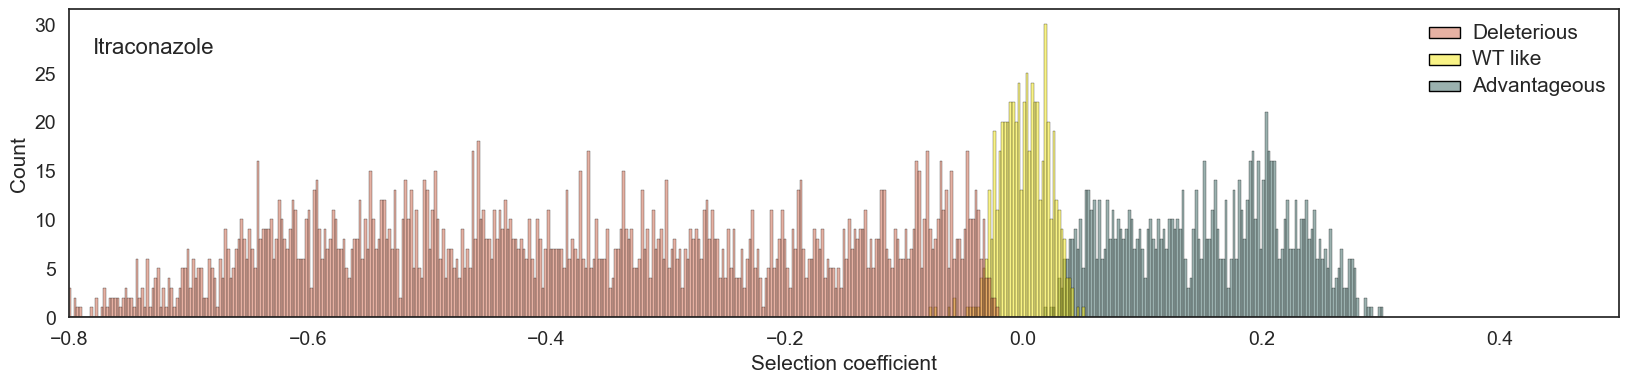

In [77]:
sns.set_style("white")
sns.set_theme(style="white", palette=None)

plt.subplots(figsize=(20, 4))
custom_palette = sns.blend_palette(["#CF6448", "#F6EA0E", "#386461"], n_colors=3)

plot = sns.histplot(data=df_del, x="select_coef", edgecolor="black", hue="result", palette=custom_palette, bins=500)

legend = plot.get_legend()  
legend.set_title("", prop={"size": 16} ) 
legend.set_frame_on(False)
for label in legend.get_texts():  
    label.set_size(15)  
    
plt.xlim(-0.8, 0.5)
#plt.title(condition + " - distribution of the selection coefficient", fontsize=20)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)

plt.xlabel('Selection coefficient', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

plt.text(-0.78,27, condition , fontsize = 16)
    
plt.rcParams['svg.fonttype'] = 'none'
name = "Distribution_" + "select_coef_t-test_results_" + condition + "_" +experiment + "_" + date 
plt.savefig(name+ ".png", transparent=True, dpi=750,format='png', bbox_inches='tight')
plt.savefig(name+ ".svg", transparent=True, dpi=750,format='svg', bbox_inches='tight')

In [78]:
#med_anti = med_anti.drop(["level_0","index"], axis=1)
med_anti = med_anti.rename(columns={"aa_variant": "variant"})
name = "Select_coeff_p_value_aa_" + condition + "_" + experiment + "_" + date + ".csv"
med_anti.to_csv(name) 

med_anti

position Antifungal aa  select_coef        p_value  adjusted_p_value  \
0           55       Itra  *    -0.395863   8.365719e-94      2.059709e-93   
1           55       Itra  A    -0.065143   3.304806e-07      3.968875e-07   
2           55       Itra  C    -0.063481   3.798459e-08      4.628466e-08   
3           55       Itra  D    -0.481650  3.424208e-189     1.697043e-188   
4           55       Itra  E    -0.393626  9.413841e-157     3.418429e-156   
...        ...        ... ..          ...            ...               ...   
4017       511       Itra  S     0.089482   2.604648e-11      3.311784e-11   
4018       511       Itra  T    -0.093856   4.042538e-11      5.124739e-11   
4019       511       Itra  V    -0.075843   5.968559e-08      7.251998e-08   
4020       511       Itra  W    -0.227904   7.622275e-28      1.139771e-27   
4021       511       Itra  Y    -0.364939  1.632802e-114     4.506674e-114   

     variant  
0        55*  
1        55A  
2        55C  
3        55D  
4        55E  
...      ...  
4017    511S  
4018    511T  
4019    511V  
4020    511W  
4021    511Y  

[4022 rows x 7 columns]